In [225]:
import os
import time
import datetime
import itertools
import cartopy
import matplotlib
import tqdm
import csv 
import geopandas as gpd
import rasterio as rio
import fiona
from mpl_toolkits.basemap import Basemap

import numpy as np
from numpy import dot
from numpy.linalg import norm
import pandas as pd
import rsfuncs as rs
import seaborn as sns
import geopandas as gp
from sklearn.preprocessing import MinMaxScaler
sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from matplotlib.lines import Line2D
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from descartes import PolygonPatch
from itertools import combinations
from collections import OrderedDict 

import datetime as dt
import xarray as xr
import rioxarray

from rasterio.enums import Resampling
from matplotlib import dates
from shapely.geometry import mapping
import sys

### Load ET Data and Shapefiles

In [2]:
butte_openet = xr.open_dataset("../data/et_images/et_images_butte/butte_openet_images.nc")
butte_openet_2 = xr.open_dataset("../data/et_images/et_images_butte/butte_openet_images_2.nc")
butte_openet['x'] = butte_openet['x'] + 0.014
butte_openet_2['x'] = butte_openet_2['x'] + 0.014
vina_openet = xr.open_dataset("../data/et_images/et_images_vina/vina_openet_images.nc")
vina_openet_2 = xr.open_dataset("../data/et_images/et_images_vina/vina_openet_images_2.nc")
vina_openet['x'] = vina_openet['x'] + 0.014
vina_openet_2['x'] = vina_openet_2['x'] + 0.014
wyandotte_openet = xr.open_dataset("../data/et_images/et_images_wyandotte/wyandotte_openet_images.nc")
wyandotte_openet_2 = xr.open_dataset("../data/et_images/et_images_wyandotte/wyandotte_openet_images_2.nc")
wyandotte_openet['x'] = wyandotte_openet['x'] + 0.014
wyandotte_openet_2['x'] = wyandotte_openet_2['x'] + 0.014

In [3]:
butte_openet_2 = butte_openet_2.set_coords("spatial_ref")
vina_openet_2 = vina_openet_2.set_coords("spatial_ref")
wyandotte_openet_2 = wyandotte_openet_2.set_coords("spatial_ref")

In [4]:
butte_openet_2 = butte_openet_2.rio.reproject_match(butte_openet)
vina_openet_2 = vina_openet_2.rio.reproject_match(vina_openet)
wyandotte_openet_2 = wyandotte_openet_2.rio.reproject_match(wyandotte_openet)

In [5]:
butte_openet_2 = butte_openet_2.sel(
    time=slice('2016-01-01', '2021-12-01'))
vina_openet_2 = vina_openet_2.sel(
    time=slice('2016-01-01', '2021-12-01'))
wyandotte_openet_2 = wyandotte_openet_2.sel(
    time=slice('2016-01-01', '2021-12-01'))

In [6]:
#butte_openet['et_ensemble_mad_index'] = butte_openet_2['et_ensemble_mad_index'].isel
#vina_openet['et_ensemble_mad_index'] = vina_openet_2['et_ensemble_mad_index']
#wyandotte_openet['et_ensemble_mad_index'] = wyandotte_openet_2['et_ensemble_mad_index']

In [7]:
#butte_openet_2 = butte_openet_2.drop("spatial_ref")
#vina_openet_2 = vina_openet_2.drop("spatial_ref")
#wyandotte_openet_2 = wyandotte_openet_2.drop("spatial_ref")

In [8]:
#butte_openet = butte_openet.merge(butte_openet_2)
#vina_openet = vina_openet.merge(vina_openet_2)
#wyandotte_openet = wyandotte_openet.merge(wyandotte_openet_2)

#butte_openet = xr.concat([butte_openet, butte_openet_2])

In [9]:
#np.set_printoptions(threshold=sys.maxsize)

In [10]:
index_values = np.unique(butte_openet_2['et_ensemble_mad_index'].values)[:15].tolist()
print(index_values)
binary_values = []
for index in index_values:
    binary_values.append(format(int(index), '#08b')[2:])
print(binary_values)
array_values = butte_openet_2['et_ensemble_mad_index'].values
array_values = array_values[~np.isnan(array_values)]

dropped_count = [0,0,0,0,0,0]
for value in array_values:
    binary_string = format(int(value), '#08b')[2:]
    for i in range(len(binary_string)):
        if binary_string[i] == '0':
            dropped_count[i] += 1
print(dropped_count)
print(len(array_values))
### 15 - no DisALEXI or EEMETRIC
### 27 - no DisALEXI or PTJPL
### 29 - no DisALEXI or SIMS
### 30 - no DisALEXI or SSEBop
### 31 - no DisALEXI
### 39 - no EEMETRIC or gEESEBAL
### 43 - no EEMETRIC or PTJPL
### 45 - no EEMETRIC or SIMS
### 46 - no EEMETRIC or SSEBop
### 47 - no EEMETRIC

#drop_disalexi = np.zeros(np.shape(butte_openet['et_ensemble_mad_index'].values))


[1.0, 2.0, 3.0, 15.0, 23.0, 27.0, 29.0, 30.0, 31.0, 36.0, 37.0, 39.0, 43.0, 44.0, 45.0]
['000001', '000010', '000011', '001111', '010111', '011011', '011101', '011110', '011111', '100100', '100101', '100111', '101011', '101100', '101101']
[109612, 376441, 140330, 90993, 152069, 97173]
1588320


KeyError: 'et_ensemble_mad_index'

In [12]:
drop_disalexi = np.zeros(np.shape(butte_openet_2['et_ensemble_mad_index'].values))
drop_eemetric = np.zeros(np.shape(butte_openet_2['et_ensemble_mad_index'].values))
drop_geesebal = np.zeros(np.shape(butte_openet_2['et_ensemble_mad_index'].values))
drop_ptjpl = np.zeros(np.shape(butte_openet_2['et_ensemble_mad_index'].values))
drop_sims = np.zeros(np.shape(butte_openet_2['et_ensemble_mad_index'].values))
drop_ssebop = np.zeros(np.shape(butte_openet_2['et_ensemble_mad_index'].values))

bitmask = butte_openet_2['et_ensemble_mad_index'].values
print(bitmask.shape)
for t in range((bitmask.shape[0])):
    for i in range((bitmask.shape[1])):
        for j in range((bitmask.shape[2])):
            if np.isnan(bitmask[t,i,j]):
                continue
            binary_string = format(int(bitmask[t,i,j]), '#08b')[2:]
            if binary_string[0] == '1':
                drop_disalexi[t,i,j] = 1
            if binary_string[1] == '1':
                drop_eemetric[t,i,j] = 1
            if binary_string[2] == '1':
                drop_geesebal[t,i,j] = 1
            if binary_string[3] == '1':
                drop_ptjpl[t,i,j] = 1
            if binary_string[4] == '1':
                drop_sims[t,i,j] = 1
            if binary_string[5] == '1':
                drop_ssebop[t,i,j] = 1

(72, 238, 174)


In [13]:
butte_openet['DisALEXI_ET'] = butte_openet['DisALEXI_ET'].where(drop_disalexi)
butte_openet['eeMETRIC_ET'] = butte_openet['eeMETRIC_ET'].where(drop_eemetric)
butte_openet['geeSEBAL_ET'] = butte_openet['geeSEBAL_ET'].where(drop_geesebal)
butte_openet['PT-JPL_ET'] = butte_openet['PT-JPL_ET'].where(drop_ptjpl)
butte_openet['SIMS_ET'] = butte_openet['SIMS_ET'].where(drop_sims)
butte_openet['SSEBop_ET'] = butte_openet['SSEBop_ET'].where(drop_ssebop)

In [14]:
drop_disalexi = np.zeros(np.shape(vina_openet_2['et_ensemble_mad_index'].values))
drop_eemetric = np.zeros(np.shape(vina_openet_2['et_ensemble_mad_index'].values))
drop_geesebal = np.zeros(np.shape(vina_openet_2['et_ensemble_mad_index'].values))
drop_ptjpl = np.zeros(np.shape(vina_openet_2['et_ensemble_mad_index'].values))
drop_sims = np.zeros(np.shape(vina_openet_2['et_ensemble_mad_index'].values))
drop_ssebop = np.zeros(np.shape(vina_openet_2['et_ensemble_mad_index'].values))

bitmask = vina_openet_2['et_ensemble_mad_index'].values
print(bitmask.shape)
for t in range((bitmask.shape[0])):
    for i in range((bitmask.shape[1])):
        for j in range((bitmask.shape[2])):
            if np.isnan(bitmask[t,i,j]):
                continue
            binary_string = format(int(bitmask[t,i,j]), '#08b')[2:]
            if binary_string[0] == '1':
                drop_disalexi[t,i,j] = 1
            if binary_string[1] == '1':
                drop_eemetric[t,i,j] = 1
            if binary_string[2] == '1':
                drop_geesebal[t,i,j] = 1
            if binary_string[3] == '1':
                drop_ptjpl[t,i,j] = 1
            if binary_string[4] == '1':
                drop_sims[t,i,j] = 1
            if binary_string[5] == '1':
                drop_ssebop[t,i,j] = 1
                
vina_openet['DisALEXI_ET'] = vina_openet['DisALEXI_ET'].where(drop_disalexi)
vina_openet['eeMETRIC_ET'] = vina_openet['eeMETRIC_ET'].where(drop_eemetric)
vina_openet['geeSEBAL_ET'] = vina_openet['geeSEBAL_ET'].where(drop_geesebal)
vina_openet['PT-JPL_ET'] = vina_openet['PT-JPL_ET'].where(drop_ptjpl)
vina_openet['SIMS_ET'] = vina_openet['SIMS_ET'].where(drop_sims)
vina_openet['SSEBop_ET'] = vina_openet['SSEBop_ET'].where(drop_ssebop)

(72, 156, 214)


In [15]:
drop_disalexi = np.zeros(np.shape(wyandotte_openet_2['et_ensemble_mad_index'].values))
drop_eemetric = np.zeros(np.shape(wyandotte_openet_2['et_ensemble_mad_index'].values))
drop_geesebal = np.zeros(np.shape(wyandotte_openet_2['et_ensemble_mad_index'].values))
drop_ptjpl = np.zeros(np.shape(wyandotte_openet_2['et_ensemble_mad_index'].values))
drop_sims = np.zeros(np.shape(wyandotte_openet_2['et_ensemble_mad_index'].values))
drop_ssebop = np.zeros(np.shape(wyandotte_openet_2['et_ensemble_mad_index'].values))

bitmask = wyandotte_openet_2['et_ensemble_mad_index'].values
print(bitmask.shape)
for t in range((bitmask.shape[0])):
    for i in range((bitmask.shape[1])):
        for j in range((bitmask.shape[2])):
            if np.isnan(bitmask[t,i,j]):
                continue
            binary_string = format(int(bitmask[t,i,j]), '#08b')[2:]
            if binary_string[0] == '1':
                drop_disalexi[t,i,j] = 1
            if binary_string[1] == '1':
                drop_eemetric[t,i,j] = 1
            if binary_string[2] == '1':
                drop_geesebal[t,i,j] = 1
            if binary_string[3] == '1':
                drop_ptjpl[t,i,j] = 1
            if binary_string[4] == '1':
                drop_sims[t,i,j] = 1
            if binary_string[5] == '1':
                drop_ssebop[t,i,j] = 1
                
wyandotte_openet['DisALEXI_ET'] = wyandotte_openet['DisALEXI_ET'].where(drop_disalexi)
wyandotte_openet['eeMETRIC_ET'] = wyandotte_openet['eeMETRIC_ET'].where(drop_eemetric)
wyandotte_openet['geeSEBAL_ET'] = wyandotte_openet['geeSEBAL_ET'].where(drop_geesebal)
wyandotte_openet['PT-JPL_ET'] = wyandotte_openet['PT-JPL_ET'].where(drop_ptjpl)
wyandotte_openet['SIMS_ET'] = wyandotte_openet['SIMS_ET'].where(drop_sims)
wyandotte_openet['SSEBop_ET'] = wyandotte_openet['SSEBop_ET'].where(drop_ssebop)

(72, 108, 80)


In [16]:
print(np.unique(drop_disalexi, return_counts=True))

(array([0., 1.]), array([276358, 345722]))


In [17]:
wyandotte_openet['DisALEXI_ET'].isel(time=-1).plot()

In [19]:
gsa_shape = gp.read_file(
    "../shape/i03_Groundwater_Sustainability_Plan_Areas_MapService.shp"
)
cv_shape = gp.read_file("../shape/Alluvial_Bnd.shp")
gsa_shape.to_crs(3310, inplace=True)
cv_shape.to_crs(3310, inplace=True)
gsa_shape.to_crs(3310, inplace=True)
cv_shape["geometry"] = cv_shape.geometry.buffer(10000)
gsa_cv = gsa_shape.within(cv_shape.loc[0, "geometry"])
gsa_cv = gsa_shape.loc[gsa_cv]
gsa_cv_cleaned_no_small = gsa_cv
# Butte - 98
# Vina - 86
# Wyandotte - 99
gsa_id = 98
shp = gsa_cv_cleaned_no_small[gsa_cv_cleaned_no_small["GSP_ID"] == gsa_id]
area = shp.area * 1e-6
shp_degree = shp.to_crs(4326)

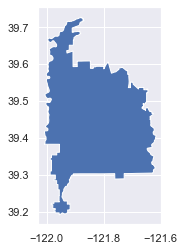

In [20]:
shp_degree.plot()

In [21]:
butte_openet['et_ensemble_mad'].isel(time=-1).plot()

In [22]:
### Rainfall

# Load preprocessed RS Data (P, R, SM, SWE) generated with 02_P_ET_SM
def load_precip_analysis(fn):
    rsdf = rs.col_to_dt(pd.read_csv(fn))
    rs_prism = np.array(rsdf['p_prism'])
    rs_gpm = np.array(rsdf['p_gpm'])
    rs_dmet = np.array(rsdf['p_dmet'])
    rs_chirps = np.array(rsdf['p_chirps'])
    rs_psn = np.array(rsdf['p_psn'])
    rs_average = np.array((rs_prism+rs_gpm+rs_dmet+rs_chirps+rs_psn)/5)
    rsdf['average'] = rs_average
    rsdf['Date'] = rsdf.index
    rsdf['water_year'] = rsdf['Date'].dt.year.where(rsdf['Date'].dt.month < 10, rsdf['Date'].dt.year + 1)
    rs_average_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y"))['average'].sum()
    rs_prism_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y"))['p_prism'].sum()
    rs_daymet_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y"))['p_dmet'].sum()
    rs_gpm_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y"))['p_gpm'].sum()
    rs_chirps_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y"))['p_chirps'].sum()
    rs_psn_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y"))['p_psn'].sum()
    
    rsdf_yearly = pd.concat([rs_average_yearly, rs_prism_yearly, rs_daymet_yearly, rs_gpm_yearly,
                           rs_chirps_yearly, rs_psn_yearly], axis=1)
    return rsdf, rsdf_yearly

def load_et_analysis(fn):
    rsdf = rs.col_to_dt(pd.read_csv(fn))
    rsdf['Date'] = rsdf.index
    rs_pet_gmet = np.array(rsdf['pet_gmet'])
    
    rsdf['water_year'] = rsdf['Date'].dt.year.where(rsdf['Date'].dt.month < 10, rsdf['Date'].dt.year + 1)
    #rs_average_yearly = rs_average.groupby(pd.PeriodIndex(rs_average['water_year'], freq="Y"))['average'].sum()
    rs_gmet_pet_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq='Y'))['pet_gmet'].sum()


    return rsdf, rs_gmet_pet_yearly
precip_butte, precip_butte_yearly = load_precip_analysis("../data/butte_rs_analysis_dat.csv")
precip_vina, precip_vina_yearly = load_precip_analysis("../data/vina_rs_analysis_dat.csv")
precip_wyandotte, precip_wyandotte_yearly = load_precip_analysis("../data/wyandotte_rs_analysis_dat.csv")

pet_butte, pet_butte_yearly = load_et_analysis("../data/butte_rs_analysis_dat.csv")
pet_vina, pet_vina_yearly = load_et_analysis("../data/vina_rs_analysis_dat.csv")
pet_wyandotte, pet_wyandotte_yearly = load_et_analysis("../data/wyandotte_rs_analysis_dat.csv")

In [23]:
pet_wyandotte_yearly

water_year
2001    0.307406
2002    0.335568
2003    0.321786
2004    0.344195
2005    0.314828
2006    0.328828
2007    0.354872
2008    0.359125
2009    0.338377
2010    0.318500
2011    0.304885
2012    0.363555
2013    0.360217
2014    0.372918
2015    0.351599
2016    0.338917
2017    0.332297
2018    0.352831
2019    0.334281
2020    0.369612
2021    0.054003
Freq: A-DEC, Name: pet_gmet, dtype: float64

In [24]:
# butte shapefile
area = gp.read_file("../shape/butte_gw_model.shp")
area_km2 = float(area.to_crs(epsg=32611).area * 1e-6)
area.to_crs(epsg=4326, inplace=True)
# subbasins

area_bs = gp.read_file("../shape/SGMA_Butte Subbasin_2018.shp")
area_bs_km2 = float(area_bs.to_crs(epsg=32611).area * 1e-6)
area_bs.to_crs(epsg=4326, inplace=True)
            
area_vs = gp.read_file("../shape/SGMA_Vina Subbasin_Bulletin 118-2018.shp")
area_vs_km2 = float(area_vs.to_crs(epsg=32611).area * 1e-6)
area_vs.to_crs(epsg=4326, inplace=True)

area_ws = gp.read_file("../shape/SGMA_Wyandotte Subbasin_2018.shp")
area_ws_km2 = float(area_ws.to_crs(epsg=32611).area * 1e-6)
area_ws.to_crs(epsg=4326, inplace=True)


In [25]:
print(area_ws_km2)
print(area_bs_km2*400*1e-6)

241.03897679875087
0.4312671071150697


In [26]:
gsa_shape = gp.read_file(
    "../shape/i03_Groundwater_Sustainability_Plan_Areas_MapService.shp"
)
cv_shape = gp.read_file("../shape/Alluvial_Bnd.shp")
gsa_shape.to_crs(3310, inplace=True)
cv_shape.to_crs(3310, inplace=True)
cv_shape["geometry"] = cv_shape.geometry.buffer(10000)
gsa_cv = gsa_shape.within(cv_shape.loc[0, "geometry"])
gsa_cv = gsa_shape.loc[gsa_cv]
gsa_cv_cleaned_no_small = gsa_cv
# Butte - 98
# Vina - 86
# Wyandotte - 99
butte_shp = gsa_cv_cleaned_no_small[gsa_cv_cleaned_no_small["GSP_ID"] == 98]
vina_shp = gsa_cv_cleaned_no_small[gsa_cv_cleaned_no_small["GSP_ID"] == 86]
wyandotte_shp = gsa_cv_cleaned_no_small[gsa_cv_cleaned_no_small["GSP_ID"] == 99]
butte_shp.to_crs(4326, inplace=True)
# shift amount 0.017

/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [27]:
cropland_data_copy = xr.open_dataset("../data/cropland/cropland_combined_3.nc")
#cv_shape_copy = gp.read_file("../shape/Alluvial_Bnd.shp")
#cv_shape_copy.to_crs(4326, inplace=True)

cropland_data_copy.rio.write_crs(4326, inplace=True)
cropland_data_copy.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

cropland_data_butte = cropland_data_copy.rio.clip(
    butte_shp.geometry.apply(mapping), butte_shp.crs, drop=True)
cropland_data_butte = cropland_data_butte.rio.reproject_match(butte_openet, resampling=Resampling.mode)
cropland_data_butte = cropland_data_butte.transpose("time", "y", "x")

cropland_data_vina = cropland_data_copy.rio.clip(
    vina_shp.geometry.apply(mapping), vina_shp.crs, drop=True)
cropland_data_vina = cropland_data_vina.rio.reproject_match(vina_openet, resampling=Resampling.mode)
cropland_data_vina = cropland_data_vina.transpose("time", "y", "x")

cropland_data_wyandotte = cropland_data_copy.rio.clip(
    wyandotte_shp.geometry.apply(mapping), wyandotte_shp.crs, drop=True)
cropland_data_wyandotte = cropland_data_wyandotte.rio.reproject_match(wyandotte_openet, resampling=Resampling.mode)
cropland_data_wyandotte = cropland_data_wyandotte.transpose("time", "y", "x")

In [28]:
cropland_data_vina

<xarray.Dataset>
Dimensions:      (time: 22, x: 214, y: 156)
Coordinates:
  * x            (x) float64 -122.1 -122.1 -122.1 ... -121.6 -121.6 -121.6
  * y            (y) float64 39.88 39.88 39.88 39.88 ... 39.54 39.54 39.54 39.53
  * time         (time) datetime64[ns] 2000-01-01 2001-01-01 ... 2021-01-01
    spatial_ref  int64 0
Data variables:
    cropland     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    transform:               [ 2.24578821e-03  0.00000000e+00 -1.24746798e+02...
    crs:                     +init=epsg:4326
    res:                     [0.00224579 0.00224579]
    is_tiled:                1
    nodatavals:              -32768.0
    scales:                  1.0
    offsets:                 0.0
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    grid_mapping:            spatial_ref

In [29]:
# grab cropland for 2016
# filter ET data for WY 2016 (October 2015-September 2016)
# create boolean mask for every land use in cropland 2016
# determine ET range for each land use type
# repeat for all years
# average

In [30]:
sample_value = butte_openet.isel(time=-2).isel(x=-100).isel(y=-100)
model_values = np.array([sample_value['DisALEXI_ET'].values[()], sample_value['PT-JPL_ET'].values[()], sample_value['SIMS_ET'].values[()], sample_value['SSEBop_ET'].values[()], sample_value['eeMETRIC_ET'].values[()], sample_value['geeSEBAL_ET'].values[()]])
np.max(model_values)-np.min(model_values)
sample_range = butte_openet.isel(time=-2).isel(x=-100).isel(y=-100)['et_ensemble_mad_max'] - butte_openet.isel(time=-2).isel(x=-100).isel(y=-100)['et_ensemble_mad_min']
print(model_values)
for i in range(len(model_values)):
    for j in range(len(model_values)):
        if i == j: # case where we are just filtering one model
            truncated_model_values = np.delete(model_values,i)
            print(truncated_model_values)
            test_range = np.max(truncated_model_values) - np.min(truncated_model_values)
        else: # filtering two models
            truncated_model_values = np.delete(model_values,[i,j])
            test_range = np.max(truncated_model_values) - np.min(truncated_model_values)
        print(test_range)
print(sample_range.values[()])

[32. 40. 35. 30. nan 20.]
[40. 35. 30. nan 20.]
nan
nan
nan
nan
20.0
nan
nan
[32. 35. 30. nan 20.]
nan
nan
nan
15.0
nan
nan
nan
[32. 40. 30. nan 20.]
nan
nan
20.0
nan
nan
nan
nan
[32. 40. 35. nan 20.]
nan
20.0
nan
20.0
15.0
20.0
20.0
[32. 40. 35. 30. 20.]
20.0
10.0
nan
nan
nan
nan
10.0
[32. 40. 35. 30. nan]
nan
16.0


## functions for converting data

In [31]:
def convert_xarray_openet_to_pandas(xarray):
    pd_dataframe = ({'DisALEXI_ET': xarray['DisALEXI_ET'].values[()],
                    'PT-JPL_ET': xarray['PT-JPL_ET'].values[()],
                    'SIMS_ET': xarray['SIMS_ET'].values[()],
                    'SSEBop_ET': xarray['SSEBop_ET'].values[()],
                    'eeMETRIC_ET': xarray['eeMETRIC_ET'].values[()],
                    'geeSEBAL_ET': xarray['geeSEBAL_ET'].values[()],
                    'et_ensemble_mad': xarray['et_ensemble_mad'].values[()],
                    'et_ensemble_mad_max': xarray['et_ensemble_mad_max'].values[()],
                    'et_ensemble_mad_min': xarray['et_ensemble_mad_min'].values[()]})
    return pd_dataframe

In [32]:
def merge_xarray_dicts(dict0, dict1):
    '''Merge xarrays contained within standard crop dictionary
    '''
    return_dict = {}
    return_dict['shrubland'] = dict0['shrubland'].merge(dict1['shrubland'])
    return_dict['fallowed'] = dict0['fallowed'].merge(dict1['fallowed'])
    return_dict['tree'] = dict0['tree'].merge(dict1['tree'])
    return_dict['grapes'] = dict0['grapes'].merge(dict1['grapes'])
    return_dict['fruit'] = dict0['fruit'].merge(dict1['fruit'])
    return_dict['rice'] = dict0['rice'].merge(dict1['rice'])
    return_dict['field'] = dict0['field'].merge(dict1['field'])
    return return_dict

def merge_irrigated_xarray_dicts(dict0, dict1):
    '''Merge xarrays contained within standard crop dictionary
    '''
    return_dict = {}
    return_dict['shrubland'] = dict0['shrubland'].merge(dict1['shrubland'])
    return_dict['fallowed'] = dict0['fallowed'].merge(dict1['fallowed'])
    return_dict['irrigated'] = dict0['irrigated'].merge(dict1['irrigated'])
    return return_dict

In [33]:
def transform_cropland(cropland):
    '''Transform a cropland array into a new format.
    '''
    desired_classifications = [1, 3, 6, 10, 24, 36, 54, 61, 69, 75, 76, 111, 121, 122, 123, 124,
                               142, 143, 152, 176, 195, 220, 204, 225]
    new_cropland = cropland.copy()
    new_cropland[~np.isin(cropland, desired_classifications)] = 0 # water/void
    new_cropland[cropland==111] = 1 # Openwater
    new_cropland[np.isin(cropland, [152,176,142,143,195])] = 2 # shrubland
    new_cropland[np.isin(cropland, [121, 123, 122,124])] = 3 # Developed
    new_cropland[cropland==61] = 4 # Fallowed
    new_cropland[np.isin(cropland,[75,76,204])] = 5 # Tree Nuts
    new_cropland[cropland==69] = 6 # Grapes
    new_cropland[np.isin(cropland,[54,10,220])] = 7 # Other Fruits
    new_cropland[cropland==3] = 8 #Rice
    new_cropland[np.isin(cropland, [36,1,225,24,6])] = 9 # Field Crop
    # 220 = plums
    # 1 = corn
    # 6 - sunflower
    
    
    return new_cropland

In [34]:
def transform_cropland_irrigated(cropland):
    '''Transform a cropland array into a new format, just looking at irrigated/nonirrigated.
    '''
    desired_classifications = [1, 3, 6, 10, 24, 36, 54, 61, 69, 75, 76, 111, 121, 122, 123, 124,
                               142, 143, 152, 176, 195, 220, 204, 225]
    new_cropland = cropland.copy()
    new_cropland[~np.isin(cropland, desired_classifications)] = 0 # water/void
    new_cropland[cropland==111] = 1 # Openwater
    new_cropland[np.isin(cropland, [152,176,142,143,195])] = 2 # shrubland
    new_cropland[np.isin(cropland, [121, 123, 122,124])] = 3 # Developed
    new_cropland[cropland==61] = 4 # Fallowed
    new_cropland[np.isin(cropland,[75,76,204,69,54,10,220,3,36,1,225,24,6])] = 5 # Irrigated
    #new_cropland[cropland==69] = 6 # Grapes
    #new_cropland[np.isin(cropland,[54,10,220])] = 7 # Other Fruits
    #new_cropland[cropland==3] = 8 #Rice
    #new_cropland[np.isin(cropland, [36,1,225,24,6])] = 9 # Field Crop
    # 220 = plums
    # 1 = corn
    # 6 - sunflower
    
    
    return new_cropland

## functions for computing et for each crop type

In [35]:
def compute_crop_type_et(cropland, openet):
    '''Compute cropland statistics
    '''
    cropland_array = transform_cropland(np.array(cropland))
    
    openet_shrubland = xr.where(cropland_array==2, openet, np.nan)
    openet_fallowed = xr.where(cropland_array==4, openet, np.nan)
    openet_tree = xr.where(cropland_array==5, openet, np.nan)
    openet_grapes = xr.where(cropland_array==6, openet, np.nan)
    openet_fruit = xr.where(cropland_array==7, openet, np.nan)
    openet_rice = xr.where(cropland_array==8, openet, np.nan)
    openet_field = xr.where(cropland_array==9, openet, np.nan)
    
    openet_shrubland_mean = openet_shrubland.mean(['x','y'])
    openet_fallowed_mean = openet_fallowed.mean(['x','y'])
    openet_tree_mean = openet_tree.mean(['x','y'])
    openet_grapes_mean = openet_grapes.mean(['x','y'])
    openet_fruit_mean = openet_fruit.mean(['x','y'])
    openet_rice_mean = openet_rice.mean(['x','y'])
    openet_field_mean = openet_field.mean(['x','y'])
    
    openet_shrubland_pd = convert_xarray_openet_to_pandas(openet_shrubland_mean)
    openet_fallowed_pd = convert_xarray_openet_to_pandas(openet_fallowed_mean)
    openet_tree_pd = convert_xarray_openet_to_pandas(openet_tree_mean)
    openet_grapes_pd = convert_xarray_openet_to_pandas(openet_grapes_mean)
    openet_fruit_pd = convert_xarray_openet_to_pandas(openet_fruit_mean)
    openet_rice_pd = convert_xarray_openet_to_pandas(openet_rice_mean)
    openet_field_pd = convert_xarray_openet_to_pandas(openet_field_mean)
    return {'shrubland': openet_shrubland_pd, 'fallowed': openet_fallowed_pd, 'tree': openet_tree_pd,
        'grapes': openet_grapes_pd, 'fruit': openet_fruit_pd, 'rice': openet_rice_pd, 'field': openet_field_pd}

def compute_crop_type_et_irrigated(cropland, openet):
    '''Compute cropland statistics
    '''
    cropland_array = transform_cropland(np.array(cropland))
    
    openet_shrubland = xr.where(cropland_array==2, openet, np.nan)
    openet_fallowed = xr.where(cropland_array==4, openet, np.nan)
    openet_irrigated = xr.where(cropland_array==5, openet, np.nan)
    
    openet_shrubland_mean = openet_shrubland.mean(['x','y'])
    openet_fallowed_mean = openet_fallowed.mean(['x','y'])
    openet_irrigated_mean = openet_irrigated.mean(['x','y'])
    
    openet_shrubland_pd = convert_xarray_openet_to_pandas(openet_shrubland_mean)
    openet_fallowed_pd = convert_xarray_openet_to_pandas(openet_fallowed_mean)
    openet_irrigated_pd = convert_xarray_openet_to_pandas(openet_irrigated_mean)

    return {'shrubland': openet_shrubland_pd, 'fallowed': openet_fallowed_pd, 'irrigated': openet_irrigated_pd}

In [36]:
def unpack_results(crop, results):
    '''unpack results and give time series
    '''
    results = [results[i][crop] for i in range(len(results))]
    
    dislaexi_results = [results[i]['DisALEXI_ET'] for i in range(len(results))]
    PT_JPL_results = [results[i]['PT-JPL_ET'] for i in range(len(results))]
    SIMS_results = [results[i]['SIMS_ET'] for i in range(len(results))]
    SSEBop_results = [results[i]['SSEBop_ET'] for i in range(len(results))]
    eeMETRIC_results = [results[i]['eeMETRIC_ET'] for i in range(len(results))]
    geeSEBAL_results = [results[i]['geeSEBAL_ET'] for i in range(len(results))]
    ensemble_results = [results[i]['et_ensemble_mad'] for i in range(len(results))]
    range_results = [results[i]['et_ensemble_mad_max']-results[i]['et_ensemble_mad_min'] for i in range(len(results))]
    
    return {'DisALEXI_ET': dislaexi_results, 'PT-JPL_ET': PT_JPL_results,
            'SIMS_ET': SIMS_results, 'SSEBop_ET': SSEBop_results,
            'eeMETRIC_ET': eeMETRIC_results, 'geeSEBAL_ET': geeSEBAL_results,
            'ensemble_ET': ensemble_results, 'ET_range': range_results}


In [37]:
def compute_crop_type_simple(cropland, openet):
    '''Compute cropland statistics
    '''
    cropland_array = transform_cropland(np.array(cropland))
    
    openet_shrubland = xr.where(cropland_array==2, openet, np.nan)
    openet_fallowed = xr.where(cropland_array==4, openet, np.nan)
    openet_tree = xr.where(cropland_array==5, openet, np.nan)
    openet_grapes = xr.where(cropland_array==6, openet, np.nan)
    openet_fruit = xr.where(cropland_array==7, openet, np.nan)
    openet_rice = xr.where(cropland_array==8, openet, np.nan)
    openet_field = xr.where(cropland_array==9, openet, np.nan)
     
    return {'shrubland': openet_shrubland, 'fallowed': openet_fallowed, 'tree': openet_tree,
        'grapes': openet_grapes, 'fruit': openet_fruit, 'rice': openet_rice, 'field': openet_field}

def compute_crop_type_simple_irrigated(cropland, openet):
    '''Compute cropland statistics
    '''
    cropland_array = transform_cropland_irrigated(np.array(cropland))
    
    openet_shrubland = xr.where(cropland_array==2, openet, np.nan)
    openet_fallowed = xr.where(cropland_array==4, openet, np.nan)
    openet_irrigated = xr.where(cropland_array==5, openet, np.nan)
     
    return {'shrubland': openet_shrubland, 'fallowed': openet_fallowed, 'irrigated': openet_irrigated}

## compute et averaged for each year

In [38]:
def compute_all_years_averaged(cropland_data_butte, cropland_data_vina, cropland_data_wyandotte, 
                               butte_openet, vina_openet, wyandotte_openet):
    '''Compute and return for all years the cropland statistics
    '''
    butte_results = []
    vina_results = []
    wyandotte_results = []
    ### 2017
    cropland_times = ['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01']
    openet_start_times = ['2016-10-01', '2017-10-01', '2018-10-01', '2019-10-01', '2020-10-01']
    openet_end_times = ['2017-10-01', '2018-10-01', '2019-10-01', '2020-10-01', '2021-10-01']
    
    for i in range(len(cropland_times)):
        print(i)
        butte_cropland_slice = cropland_data_butte['cropland'].sel(time=cropland_times[i])
        vina_cropland_slice = cropland_data_vina['cropland'].sel(time=cropland_times[i])
        wyandotte_cropland_slice = cropland_data_wyandotte['cropland'].sel(time=cropland_times[i])
        
        butte_openet_slice = butte_openet.sel(time=slice(openet_start_times[i], 
                                                        openet_end_times[i])).mean('time')
        vina_openet_slice = vina_openet.sel(time=slice(openet_start_times[i], 
                                                       openet_end_times[i])).mean('time')
        wyandotte_openet_slice = wyandotte_openet.sel(time=slice(openet_start_times[i], 
                                                                 openet_end_times[i])).mean('time')

        butte_openet_crop_types = compute_crop_type_et(butte_cropland_slice, butte_openet_slice)
        vina_openet_crop_types = compute_crop_type_et(vina_cropland_slice, vina_openet_slice)
        wyandotte_openet_crop_types = compute_crop_type_et(wyandotte_cropland_slice, wyandotte_openet_slice)
    
        butte_results.append(butte_openet_crop_types)
        vina_results.append(vina_openet_crop_types)
        wyandotte_results.append(wyandotte_openet_crop_types)
        
    return butte_results, vina_results, wyandotte_results

def compute_all_years_irrigated_averaged(cropland_data_butte, cropland_data_vina, cropland_data_wyandotte, 
                               butte_openet, vina_openet, wyandotte_openet):
    '''Compute and return for all years the cropland statistics
    '''
    butte_results = []
    vina_results = []
    wyandotte_results = []
    ### 2017
    cropland_times = ['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01']
    openet_start_times = ['2016-10-01', '2017-10-01', '2018-10-01', '2019-10-01', '2020-10-01']
    openet_end_times = ['2017-10-01', '2018-10-01', '2019-10-01', '2020-10-01', '2021-10-01']
    
    for i in range(len(cropland_times)):
        print(i)
        butte_cropland_slice = cropland_data_butte['cropland'].sel(time=cropland_times[i])
        vina_cropland_slice = cropland_data_vina['cropland'].sel(time=cropland_times[i])
        wyandotte_cropland_slice = cropland_data_wyandotte['cropland'].sel(time=cropland_times[i])
        wyandotte_cropland_slice.plot()
        butte_openet_slice = butte_openet.sel(time=slice(openet_start_times[i], 
                                                        openet_end_times[i])).mean('time')
        vina_openet_slice = vina_openet.sel(time=slice(openet_start_times[i], 
                                                       openet_end_times[i])).mean('time')
        wyandotte_openet_slice = wyandotte_openet.sel(time=slice(openet_start_times[i], 
                                                                 openet_end_times[i])).mean('time')

        butte_openet_crop_types = compute_crop_type_et_irrigated(butte_cropland_slice, butte_openet_slice)
        vina_openet_crop_types = compute_crop_type_et_irrigated(vina_cropland_slice, vina_openet_slice)
        wyandotte_openet_crop_types = compute_crop_type_et_irrigated(wyandotte_cropland_slice, wyandotte_openet_slice)
    
        butte_results.append(butte_openet_crop_types)
        vina_results.append(vina_openet_crop_types)
        wyandotte_results.append(wyandotte_openet_crop_types)
        
    return butte_results, vina_results, wyandotte_results

In [39]:
def compute_all_years_climatology(cropland_data_butte, cropland_data_vina, cropland_data_wyandotte, 
                               butte_openet, vina_openet, wyandotte_openet):
    '''Compute and return for all years the cropland statistics
    '''
    butte_results = []
    vina_results = []
    wyandotte_results = []
    ### 2017
    cropland_times = ['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01']
    openet_start_times = ['2016-10-01', '2017-10-01', '2018-10-01', '2019-10-01', '2020-10-01']
    openet_end_times = ['2017-10-01', '2018-10-01', '2019-10-01', '2020-10-01', '2021-10-01']
    
    butte_crop_dicts = []
    vina_crop_dicts = []
    wyandotte_crop_dicts = []
    ### slice crop data for each year
    for i in range(len(cropland_times)):
        print(i)
        butte_cropland_slice = cropland_data_butte['cropland'].sel(time=cropland_times[i])
        vina_cropland_slice = cropland_data_vina['cropland'].sel(time=cropland_times[i])
        wyandotte_cropland_slice = cropland_data_wyandotte['cropland'].sel(time=cropland_times[i])
        
        butte_openet_slice = butte_openet.sel(time=slice(openet_start_times[i], 
                                                        openet_end_times[i]))
        vina_openet_slice = vina_openet.sel(time=slice(openet_start_times[i], 
                                                       openet_end_times[i]))
        wyandotte_openet_slice = wyandotte_openet.sel(time=slice(openet_start_times[i], 
                                                                 openet_end_times[i]))
        
        butte_crop_dicts.append(compute_crop_type_simple(butte_cropland_slice, butte_openet_slice))
        vina_crop_dicts.append(compute_crop_type_simple(vina_cropland_slice, vina_openet_slice))      
        wyandotte_crop_dicts.append(compute_crop_type_simple(wyandotte_cropland_slice, wyandotte_openet_slice))
    
    butte_crop_dict_compiled = butte_crop_dicts[0]
    vina_crop_dict_compiled = vina_crop_dicts[0]
    wyandotte_crop_dict_compiled = wyandotte_crop_dicts[0]
    ### group data for climatology analysis
    for i in range(1, len(butte_crop_dicts)):
        print("grouping data")
        print(i)
        butte_crop_dict_compiled = merge_xarray_dicts(butte_crop_dict_compiled, butte_crop_dicts[i])
        vina_crop_dict_compiled = merge_xarray_dicts(vina_crop_dict_compiled, vina_crop_dicts[i])
        wyandotte_crop_dict_compiled = merge_xarray_dicts(wyandotte_crop_dict_compiled, wyandotte_crop_dicts[i])
        
    butte_climatology = calculate_climatologies(butte_crop_dict_compiled)
    vina_climatology = calculate_climatologies(vina_crop_dict_compiled)
    wyandotte_climatology = calculate_climatologies(wyandotte_crop_dict_compiled)
    return butte_climatology, vina_climatology, wyandotte_climatology

def compute_all_years_irrigated_climatology(cropland_data_butte, cropland_data_vina, cropland_data_wyandotte, 
                               butte_openet, vina_openet, wyandotte_openet):
    '''Compute and return for all years the cropland statistics
    '''
    butte_results = []
    vina_results = []
    wyandotte_results = []
    ### 2017
    cropland_times = ['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01']
    openet_start_times = ['2016-10-01', '2017-10-01', '2018-10-01', '2019-10-01', '2020-10-01']
    openet_end_times = ['2017-10-01', '2018-10-01', '2019-10-01', '2020-10-01', '2021-10-01']
    
    butte_crop_dicts = []
    vina_crop_dicts = []
    wyandotte_crop_dicts = []
    ### slice crop data for each year
    for i in range(len(cropland_times)):
        print(i)
        butte_cropland_slice = cropland_data_butte['cropland'].sel(time=cropland_times[i])
        vina_cropland_slice = cropland_data_vina['cropland'].sel(time=cropland_times[i])
        wyandotte_cropland_slice = cropland_data_wyandotte['cropland'].sel(time=cropland_times[i])
        
        butte_openet_slice = butte_openet.sel(time=slice(openet_start_times[i], 
                                                        openet_end_times[i]))
        vina_openet_slice = vina_openet.sel(time=slice(openet_start_times[i], 
                                                       openet_end_times[i]))
        wyandotte_openet_slice = wyandotte_openet.sel(time=slice(openet_start_times[i], 
                                                                 openet_end_times[i]))
        
        butte_crop_dicts.append(compute_crop_type_simple_irrigated(butte_cropland_slice, butte_openet_slice))
        vina_crop_dicts.append(compute_crop_type_simple_irrigated(vina_cropland_slice, vina_openet_slice))      
        wyandotte_crop_dicts.append(compute_crop_type_simple_irrigated(wyandotte_cropland_slice, wyandotte_openet_slice))
    
    butte_crop_dict_compiled = butte_crop_dicts[0]
    vina_crop_dict_compiled = vina_crop_dicts[0]
    wyandotte_crop_dict_compiled = wyandotte_crop_dicts[0]
    ### group data for climatology analysis
    for i in range(1, len(butte_crop_dicts)):
        print("grouping data")
        print(i)
        butte_crop_dict_compiled = merge_irrigated_xarray_dicts(butte_crop_dict_compiled, butte_crop_dicts[i])
        vina_crop_dict_compiled = merge_irrigated_xarray_dicts(vina_crop_dict_compiled, vina_crop_dicts[i])
        wyandotte_crop_dict_compiled = merge_irrigated_xarray_dicts(wyandotte_crop_dict_compiled, wyandotte_crop_dicts[i])
        
    butte_climatology = calculate_irrigated_climatologies(butte_crop_dict_compiled)
    vina_climatology = calculate_irrigated_climatologies(vina_crop_dict_compiled)
    wyandotte_climatology = calculate_irrigated_climatologies(wyandotte_crop_dict_compiled)
    return butte_climatology, vina_climatology, wyandotte_climatology

In [40]:
def calculate_climatologies(et_dict):
    return_dict = {}
    
    return_dict['shrubland'] = et_dict['shrubland'].groupby('time.month').mean('time').mean(['x','y'])
    return_dict['fallowed'] = et_dict['fallowed'].groupby('time.month').mean('time').mean(['x','y'])
    return_dict['tree'] = et_dict['tree'].groupby('time.month').mean('time').mean(['x','y'])
    return_dict['grapes'] = et_dict['grapes'].groupby('time.month').mean('time').mean(['x','y'])
    return_dict['rice'] = et_dict['rice'].groupby('time.month').mean('time').mean(['x','y'])
    return_dict['fruit'] = et_dict['fruit'].groupby('time.month').mean('time').mean(['x','y'])
    return_dict['field'] = et_dict['field'].groupby('time.month').mean('time').mean(['x','y'])
    
    return return_dict

def calculate_irrigated_climatologies(et_dict):
    return_dict = {}
    return_dict['shrubland'] = et_dict['shrubland'].groupby('time.month').mean('time').mean(['x','y'])
    return_dict['fallowed'] = et_dict['fallowed'].groupby('time.month').mean('time').mean(['x','y'])
    return_dict['irrigated'] = et_dict['irrigated'].groupby('time.month').mean('time').mean(['x','y'])
    
    return return_dict

## run the functions to obtain outputs

In [41]:
butte_results_all_clim, vina_results_all_clim, wyandotte_results_all_clim = compute_all_years_climatology(cropland_data_butte,
    cropland_data_vina, cropland_data_wyandotte, butte_openet, vina_openet, wyandotte_openet)

0
1
2
3
4
grouping data
1
grouping data
2
grouping data
3
grouping data
4


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [42]:
butte_results_irrigated_clim, vina_results_irrigated_clim, wyandotte_results_irrigated_clim = compute_all_years_irrigated_climatology(cropland_data_butte,
    cropland_data_vina, cropland_data_wyandotte, butte_openet, vina_openet, wyandotte_openet)

0
1
2
3
4
grouping data
1
grouping data
2
grouping data
3
grouping data
4


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [43]:
butte_results_irrigated_clim

{'shrubland': <xarray.Dataset>
 Dimensions:              (month: 12)
 Coordinates:
   * month                (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
 Data variables:
     DisALEXI_ET          (month) float64 24.98 41.96 70.95 ... 53.93 33.05 22.38
     PT-JPL_ET            (month) float64 32.54 59.62 80.78 ... 62.29 32.71 27.39
     SIMS_ET              (month) float64 30.6 44.22 70.32 ... 50.35 29.53 23.77
     SSEBop_ET            (month) float64 33.13 51.93 64.89 ... 87.43 46.74 32.11
     eeMETRIC_ET          (month) float64 30.52 53.74 65.13 ... 88.25 51.99 32.25
     et_ensemble_mad      (month) float64 29.17 48.34 69.25 ... 65.79 34.68 25.4
     et_ensemble_mad_max  (month) float64 40.36 64.7 83.84 ... 92.38 51.97 40.05
     et_ensemble_mad_min  (month) float64 17.48 31.93 54.05 ... 42.38 18.38 10.96
     geeSEBAL_ET          (month) float64 17.93 38.83 62.93 ... 53.46 19.71 10.22,
 'fallowed': <xarray.Dataset>
 Dimensions:              (month: 12)
 Coordinates:
   * month     

In [44]:
butte_results_all, vina_results_all, wyandotte_results_all = compute_all_years_averaged(cropland_data_butte,
    cropland_data_vina, cropland_data_wyandotte, butte_openet, vina_openet, wyandotte_openet)

0
1
2
3
4


0
1
2
3
4


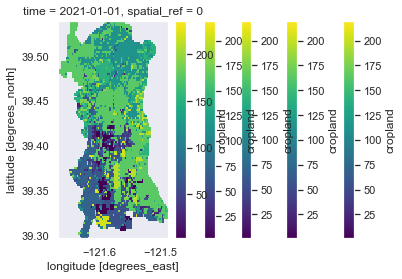

In [45]:
butte_results_irrigated_avg, vina_results_irrigated_avg, wyandotte_results_irrigated_avg = compute_all_years_irrigated_averaged(cropland_data_butte,
    cropland_data_vina, cropland_data_wyandotte, butte_openet, vina_openet, wyandotte_openet)

In [201]:
def plot_climatologies(butte_dataframe, vina_dataframe, wyandotte_dataframe):
    '''plot climatologies
    Plot monthly, find where maximum for rice vs. shrubland is. When is it peaking? Why is shrubland so high?
    
    Have insitu ET estimate, have 6 openET models, what is the level of agreement at pixel, pixel+neighbors, at basin
    
    Is OpenET acceptable at basin scale vs field scale?
    
    Variance of OpenET pixels within one pixel, pixel+neighbors, at basin
    
    Recalculate error with flux tower as more models are added.
    '''
    
    x_data = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUNE',
              'JULY', 'AUG', 'SEPT', 'OCT',
              'NOV', 'DEC']
    fig, axes = plt.subplots(3,2,figsize=(26, 18))
    axes[0,0].plot(x_data, butte_dataframe['shrubland']['DisALEXI_ET'], label='DisALEXI', linewidth=2.5)
    axes[0,0].plot(x_data, butte_dataframe['shrubland']['eeMETRIC_ET'], label='eeMETRIC', linewidth=2.5)
    axes[0,0].plot(x_data, butte_dataframe['shrubland']['geeSEBAL_ET'], label='geeSEBAL', linewidth=2.5)
    axes[0,0].plot(x_data, butte_dataframe['shrubland']['PT-JPL_ET'], label='PT-JPL', linewidth=2.5)
    #axes[0,0].plot(x_data, butte_dataframe['shrubland']['SIMS_ET'], label='SIMS')
    next(axes[0,0]._get_lines.prop_cycler)
    axes[0,0].plot(x_data, butte_dataframe['shrubland']['SSEBop_ET'], label='SSEBop', linewidth=2.5)
    
    
    axes[0,0].set_ylim(0, 200)
    axes[0,0].tick_params(axis='both', labelsize=20)
    axes[0,0].set_title('Butte Subbasin ET Climatology: Non-irrigated', fontsize=24)
    
    axes[0,1].plot(x_data, butte_dataframe['irrigated']['DisALEXI_ET'], label='DisALEXI', linewidth=2.5)
    axes[0,1].plot(x_data, butte_dataframe['irrigated']['eeMETRIC_ET'], label='eeMETRIC', linewidth=2.5)
    axes[0,1].plot(x_data, butte_dataframe['irrigated']['geeSEBAL_ET'], label='geeSEBAL', linewidth=2.5)
    axes[0,1].plot(x_data, butte_dataframe['irrigated']['PT-JPL_ET'], label='PT-JPL', linewidth=2.5)
    axes[0,1].plot(x_data, butte_dataframe['irrigated']['SIMS_ET'], label='SIMS', linewidth=2.5)
    axes[0,1].plot(x_data, butte_dataframe['irrigated']['SSEBop_ET'], label='SSEBop', linewidth=2.5)
    
     
    axes[0,1].tick_params(axis='both', labelsize=20)
    axes[0,1].set_ylim(0, 200)
    axes[0,1].set_title('Butte Subbasin ET Climatology: Irrigated', fontsize=24)
    axes[0,1].legend(fontsize=20, bbox_to_anchor=(1.25, 1))
    
    axes[1,0].plot(x_data, vina_dataframe['shrubland']['DisALEXI_ET'], label='DisALEXI', linewidth=2.5)
    axes[1,0].plot(x_data, vina_dataframe['shrubland']['eeMETRIC_ET'], label='eeMETRIC', linewidth=2.5)
    axes[1,0].plot(x_data, vina_dataframe['shrubland']['geeSEBAL_ET'], label='geeSEBAL', linewidth=2.5)
    axes[1,0].plot(x_data, vina_dataframe['shrubland']['PT-JPL_ET'], label='PT-JPL', linewidth=2.5)
    #axes[1,0].plot(x_data, vina_dataframe['shrubland']['SIMS_ET'], label='SIMS')
    next(axes[1,0]._get_lines.prop_cycler)
    axes[1,0].plot(x_data, vina_dataframe['shrubland']['SSEBop_ET'], label='SSEBop', linewidth=2.5)
    
    
    axes[1,0].tick_params(axis='both', labelsize=20)
    axes[1,0].set_ylim(0, 200)
    axes[1,0].set_ylabel('Evapotranspiration (mm)', fontsize=20)
    axes[1,0].set_title('Vina Subbasin ET Climatology: Non-irrigated', fontsize=24)
    
    axes[1,1].plot(x_data, vina_dataframe['irrigated']['DisALEXI_ET'], label='DisALEXI', linewidth=2.5)
    axes[1,1].plot(x_data, vina_dataframe['irrigated']['eeMETRIC_ET'], label='eeMETRIC', linewidth=2.5)
    axes[1,1].plot(x_data, vina_dataframe['irrigated']['geeSEBAL_ET'], label='geeSEBAL', linewidth=2.5)
    axes[1,1].plot(x_data, vina_dataframe['irrigated']['PT-JPL_ET'], label='PT-JPL', linewidth=2.5)
    axes[1,1].plot(x_data, vina_dataframe['irrigated']['SIMS_ET'], label='SIMS', linewidth=2.5)
    axes[1,1].plot(x_data, vina_dataframe['irrigated']['SSEBop_ET'], label='SSEBop', linewidth=2.5)
    
     
    axes[1,1].tick_params(axis='both', labelsize=20)
    axes[1,1].set_ylim(0, 200)
    axes[1,1].set_ylabel('Evapotranspiration (mm)', fontsize=20)
    axes[1,1].set_title('Vina Subbasin ET Climatology: Irrigated', fontsize=24)
    
    axes[2,0].plot(x_data, wyandotte_dataframe['shrubland']['DisALEXI_ET'], label='DisALEXI', linewidth=2.5)
    axes[2,0].plot(x_data, wyandotte_dataframe['shrubland']['eeMETRIC_ET'], label='eeMETRIC', linewidth=2.5)
    axes[2,0].plot(x_data, wyandotte_dataframe['shrubland']['geeSEBAL_ET'], label='geeSEBAL', linewidth=2.5)
    axes[2,0].plot(x_data, wyandotte_dataframe['shrubland']['PT-JPL_ET'], label='PT-JPL', linewidth=2.5)
    #axes[2,0].plot(x_data, wyandotte_dataframe['shrubland']['SIMS_ET'], label='SIMS')
    next(axes[2,0]._get_lines.prop_cycler)
    axes[2,0].plot(x_data, wyandotte_dataframe['shrubland']['SSEBop_ET'], label='SSEBop', linewidth=2.5)
    
    
    axes[2,0].tick_params(axis='both', labelsize=20)
    axes[2,0].set_ylim(0, 200)
    axes[2,0].set_title('Wyandotte Subbasin ET Climatology: Non-irrigated', fontsize=24)
    
    axes[2,1].plot(x_data, wyandotte_dataframe['irrigated']['DisALEXI_ET'], label='DisALEXI', linewidth=2.5)
    axes[2,1].plot(x_data, wyandotte_dataframe['irrigated']['eeMETRIC_ET'], label='eeMETRIC', linewidth=2.5)
    axes[2,1].plot(x_data, wyandotte_dataframe['irrigated']['geeSEBAL_ET'], label='geeSEBAL', linewidth=2.5)
    axes[2,1].plot(x_data, wyandotte_dataframe['irrigated']['PT-JPL_ET'], label='PT-JPL', linewidth=2.5)
    axes[2,1].plot(x_data, wyandotte_dataframe['irrigated']['SIMS_ET'], label='SIMS', linewidth=2.5)
    axes[2,1].plot(x_data, wyandotte_dataframe['irrigated']['SSEBop_ET'], label='SSEBop', linewidth=2.5)
    
     
    axes[2,1].tick_params(axis='both', labelsize=20)
    axes[2,1].set_ylim(0, 200)
    axes[2,1].set_title('Wyandotte Subbasin ET Climatology: Irrigated', fontsize=24)
    
    plt.tight_layout()

In [202]:
plot_climatologies(butte_results_irrigated_clim, vina_results_irrigated_clim, wyandotte_results_irrigated_clim)

In [230]:
def plot_climatologies_range(butte_dataframe, vina_dataframe, wyandotte_dataframe):
    '''plot climatologies
    Plot monthly, find where maximum for rice vs. shrubland is. When is it peaking? Why is shrubland so high?
    
    Have insitu ET estimate, have 6 openET models, what is the level of agreement at pixel, pixel+neighbors, at basin
    
    Is OpenET acceptable at basin scale vs field scale?
    
    Variance of OpenET pixels within one pixel, pixel+neighbors, at basin
    
    Recalculate error with flux tower as more models are added.
    '''
    
    x_data = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUNE',
              'JULY', 'AUG', 'SEPT', 'OCT',
              'NOV', 'DEC']
    fig, axes = plt.subplots(3,2,figsize=(26, 18))
    axes[0,0].plot(x_data, butte_dataframe['shrubland']['et_ensemble_mad_max']-butte_dataframe['shrubland']['et_ensemble_mad_min'], label='Shrubland', linewidth=2.5)
    axes[0,0].plot(x_data, butte_dataframe['fallowed']['et_ensemble_mad_max']-butte_dataframe['fallowed']['et_ensemble_mad_min'], label='Fallowed', linewidth=2.5)
    axes[0,0].plot(x_data, butte_dataframe['tree']['et_ensemble_mad_max']-butte_dataframe['tree']['et_ensemble_mad_min'], label='Tree Nuts', linewidth=2.5)
    axes[0,0].plot(x_data, butte_dataframe['grapes']['et_ensemble_mad_max']-butte_dataframe['grapes']['et_ensemble_mad_min'], label='Grape', linewidth=2.5)
    axes[0,0].plot(x_data, butte_dataframe['fruit']['et_ensemble_mad_max']-butte_dataframe['fruit']['et_ensemble_mad_min'], label='Other Fruit', linewidth=2.5)
    axes[0,0].plot(x_data, butte_dataframe['rice']['et_ensemble_mad_max']-butte_dataframe['rice']['et_ensemble_mad_min'], label='Rice', linewidth=2.5)
    axes[0,0].plot(x_data, butte_dataframe['field']['et_ensemble_mad_max']-butte_dataframe['field']['et_ensemble_mad_min'], label='Field', linewidth=2.5)
    
    axes[0,0].tick_params(axis='both', labelsize=20)
    axes[0,0].set_ylim(0, 70)
    axes[0,0].set_title('Butte Subbasin ET Uncertainty Climatology', fontsize=24)
    
    
    axes[0,1].plot(x_data, np.cumsum(butte_dataframe['shrubland']['et_ensemble_mad_max']-butte_dataframe['shrubland']['et_ensemble_mad_min']), label='Shrubland', linewidth=2.5)
    axes[0,1].plot(x_data, np.cumsum(butte_dataframe['fallowed']['et_ensemble_mad_max']-butte_dataframe['fallowed']['et_ensemble_mad_min']), label='Fallowed', linewidth=2.5)
    axes[0,1].plot(x_data, np.cumsum(butte_dataframe['tree']['et_ensemble_mad_max']-butte_dataframe['tree']['et_ensemble_mad_min']), label='Tree Nuts', linewidth=2.5)
    axes[0,1].plot(x_data, np.cumsum(butte_dataframe['grapes']['et_ensemble_mad_max']-butte_dataframe['grapes']['et_ensemble_mad_min']), label='Grape', linewidth=2.5)
    axes[0,1].plot(x_data, np.cumsum(butte_dataframe['fruit']['et_ensemble_mad_max']-butte_dataframe['fruit']['et_ensemble_mad_min']), label='Other Fruit', linewidth=2.5)
    axes[0,1].plot(x_data, np.cumsum(butte_dataframe['rice']['et_ensemble_mad_max']-butte_dataframe['rice']['et_ensemble_mad_min']), label='Rice', linewidth=2.5)
    axes[0,1].plot(x_data, np.cumsum(butte_dataframe['field']['et_ensemble_mad_max']-butte_dataframe['field']['et_ensemble_mad_min']), label='Field', linewidth=2.5)
     
    axes[0,1].tick_params(axis='both', labelsize=20)
    axes[0,1].set_ylim(0, 500)
    axes[0,1].set_title('Butte Subbasin ET Uncertainty Climatology: Cumulative Sum', fontsize=24)
    axes[0,1].legend(fontsize=20,  bbox_to_anchor=(1.25, 1))
    
    axes[1,0].plot(x_data, vina_dataframe['shrubland']['et_ensemble_mad_max']-vina_dataframe['shrubland']['et_ensemble_mad_min'], label='Shrubland', linewidth=2.5)
    axes[1,0].plot(x_data, vina_dataframe['fallowed']['et_ensemble_mad_max']-vina_dataframe['fallowed']['et_ensemble_mad_min'], label='Fallowed', linewidth=2.5)
    axes[1,0].plot(x_data, vina_dataframe['tree']['et_ensemble_mad_max']-vina_dataframe['tree']['et_ensemble_mad_min'], label='Tree Nuts', linewidth=2.5)
    axes[1,0].plot(x_data, vina_dataframe['grapes']['et_ensemble_mad_max']-vina_dataframe['grapes']['et_ensemble_mad_min'], label='Grape', linewidth=2.5)
    axes[1,0].plot(x_data, vina_dataframe['fruit']['et_ensemble_mad_max']-vina_dataframe['fruit']['et_ensemble_mad_min'], label='Other Fruit', linewidth=2.5)
    axes[1,0].plot(x_data, vina_dataframe['rice']['et_ensemble_mad_max']-vina_dataframe['rice']['et_ensemble_mad_min'], label='Rice', linewidth=2.5)
    axes[1,0].plot(x_data, vina_dataframe['field']['et_ensemble_mad_max']-vina_dataframe['field']['et_ensemble_mad_min'], label='Field', linewidth=2.5)
    
    axes[1,0].tick_params(axis='both', labelsize=20)
    axes[1,0].set_ylabel('OpenET Range (mm)', fontsize=20)
    axes[1,0].set_ylim(0, 70)
    axes[1,0].set_title('Vina Subbasin ET Uncertainty Climatology', fontsize=24)
    
    axes[1,1].plot(x_data, np.cumsum(vina_dataframe['shrubland']['et_ensemble_mad_max']-vina_dataframe['shrubland']['et_ensemble_mad_min']), label='Shrubland', linewidth=2.5)
    axes[1,1].plot(x_data, np.cumsum(vina_dataframe['fallowed']['et_ensemble_mad_max']-vina_dataframe['fallowed']['et_ensemble_mad_min']), label='Fallowed', linewidth=2.5)
    axes[1,1].plot(x_data, np.cumsum(vina_dataframe['tree']['et_ensemble_mad_max']-vina_dataframe['tree']['et_ensemble_mad_min']), label='Tree Nuts', linewidth=2.5)
    axes[1,1].plot(x_data, np.cumsum(vina_dataframe['grapes']['et_ensemble_mad_max']-vina_dataframe['grapes']['et_ensemble_mad_min']), label='Grape', linewidth=2.5)
    axes[1,1].plot(x_data, np.cumsum(vina_dataframe['fruit']['et_ensemble_mad_max']-vina_dataframe['fruit']['et_ensemble_mad_min']), label='Other Fruit', linewidth=2.5)
    axes[1,1].plot(x_data, np.cumsum(vina_dataframe['rice']['et_ensemble_mad_max']-vina_dataframe['rice']['et_ensemble_mad_min']), label='Rice', linewidth=2.5)
    axes[1,1].plot(x_data, np.cumsum(vina_dataframe['field']['et_ensemble_mad_max']-vina_dataframe['field']['et_ensemble_mad_min']), label='Field', linewidth=2.5)
     
    axes[1,1].tick_params(axis='both', labelsize=20)
    axes[1,1].set_ylabel('OpenET Range (mm)', fontsize=20)
    axes[1,1].set_ylim(0, 500)
    axes[1,1].set_title('Vina Subbasin ET Uncertainty Climatology: Cumulative Sum', fontsize=24)
    
    axes[2,0].plot(x_data, wyandotte_dataframe['shrubland']['et_ensemble_mad_max']-wyandotte_dataframe['shrubland']['et_ensemble_mad_min'], label='Shrubland', linewidth=2.5)
    axes[2,0].plot(x_data, wyandotte_dataframe['fallowed']['et_ensemble_mad_max']-wyandotte_dataframe['fallowed']['et_ensemble_mad_min'], label='Fallowed', linewidth=2.5)
    axes[2,0].plot(x_data, wyandotte_dataframe['tree']['et_ensemble_mad_max']-wyandotte_dataframe['tree']['et_ensemble_mad_min'], label='Tree Nuts', linewidth=2.5)
    axes[2,0].plot(x_data, wyandotte_dataframe['grapes']['et_ensemble_mad_max']-wyandotte_dataframe['grapes']['et_ensemble_mad_min'], label='Grape', linewidth=2.5)
    axes[2,0].plot(x_data, wyandotte_dataframe['fruit']['et_ensemble_mad_max']-wyandotte_dataframe['fruit']['et_ensemble_mad_min'], label='Other Fruit', linewidth=2.5)
    axes[2,0].plot(x_data, wyandotte_dataframe['rice']['et_ensemble_mad_max']-wyandotte_dataframe['rice']['et_ensemble_mad_min'], label='Rice', linewidth=2.5)
    axes[2,0].plot(x_data, wyandotte_dataframe['field']['et_ensemble_mad_max']-wyandotte_dataframe['field']['et_ensemble_mad_min'], label='Field', linewidth=2.5)
    
    axes[2,0].tick_params(axis='both', labelsize=20)
    axes[2,0].set_ylim(0, 70)
    axes[2,0].set_title('Wyandotte Subbasin ET Uncertainty Climatology', fontsize=24)
    
    axes[2,1].plot(x_data, np.cumsum(wyandotte_dataframe['shrubland']['et_ensemble_mad_max']-wyandotte_dataframe['shrubland']['et_ensemble_mad_min']), label='Shrubland', linewidth=2.5)
    axes[2,1].plot(x_data, np.cumsum(wyandotte_dataframe['fallowed']['et_ensemble_mad_max']-wyandotte_dataframe['fallowed']['et_ensemble_mad_min']), label='Fallowed', linewidth=2.5)
    axes[2,1].plot(x_data, np.cumsum(wyandotte_dataframe['tree']['et_ensemble_mad_max']-wyandotte_dataframe['tree']['et_ensemble_mad_min']), label='Tree Nuts', linewidth=2.5)
    axes[2,1].plot(x_data, np.cumsum(wyandotte_dataframe['grapes']['et_ensemble_mad_max']-wyandotte_dataframe['grapes']['et_ensemble_mad_min']), label='Grape', linewidth=2.5)
    axes[2,1].plot(x_data, np.cumsum(wyandotte_dataframe['fruit']['et_ensemble_mad_max']-wyandotte_dataframe['fruit']['et_ensemble_mad_min']), label='Other Fruit', linewidth=2.5)
    axes[2,1].plot(x_data, np.cumsum(wyandotte_dataframe['rice']['et_ensemble_mad_max']-wyandotte_dataframe['rice']['et_ensemble_mad_min']), label='Rice', linewidth=2.5)
    axes[2,1].plot(x_data, np.cumsum(wyandotte_dataframe['field']['et_ensemble_mad_max']-wyandotte_dataframe['field']['et_ensemble_mad_min']), label='Field', linewidth=2.5)
     
    axes[2,1].tick_params(axis='both', labelsize=20)
    axes[2,1].set_ylim(0, 500)
    axes[2,1].set_title('Wyandotte Subbasin ET Uncertainty Climatology: Cumulative Sum', fontsize=24)
    
    plt.tight_layout()

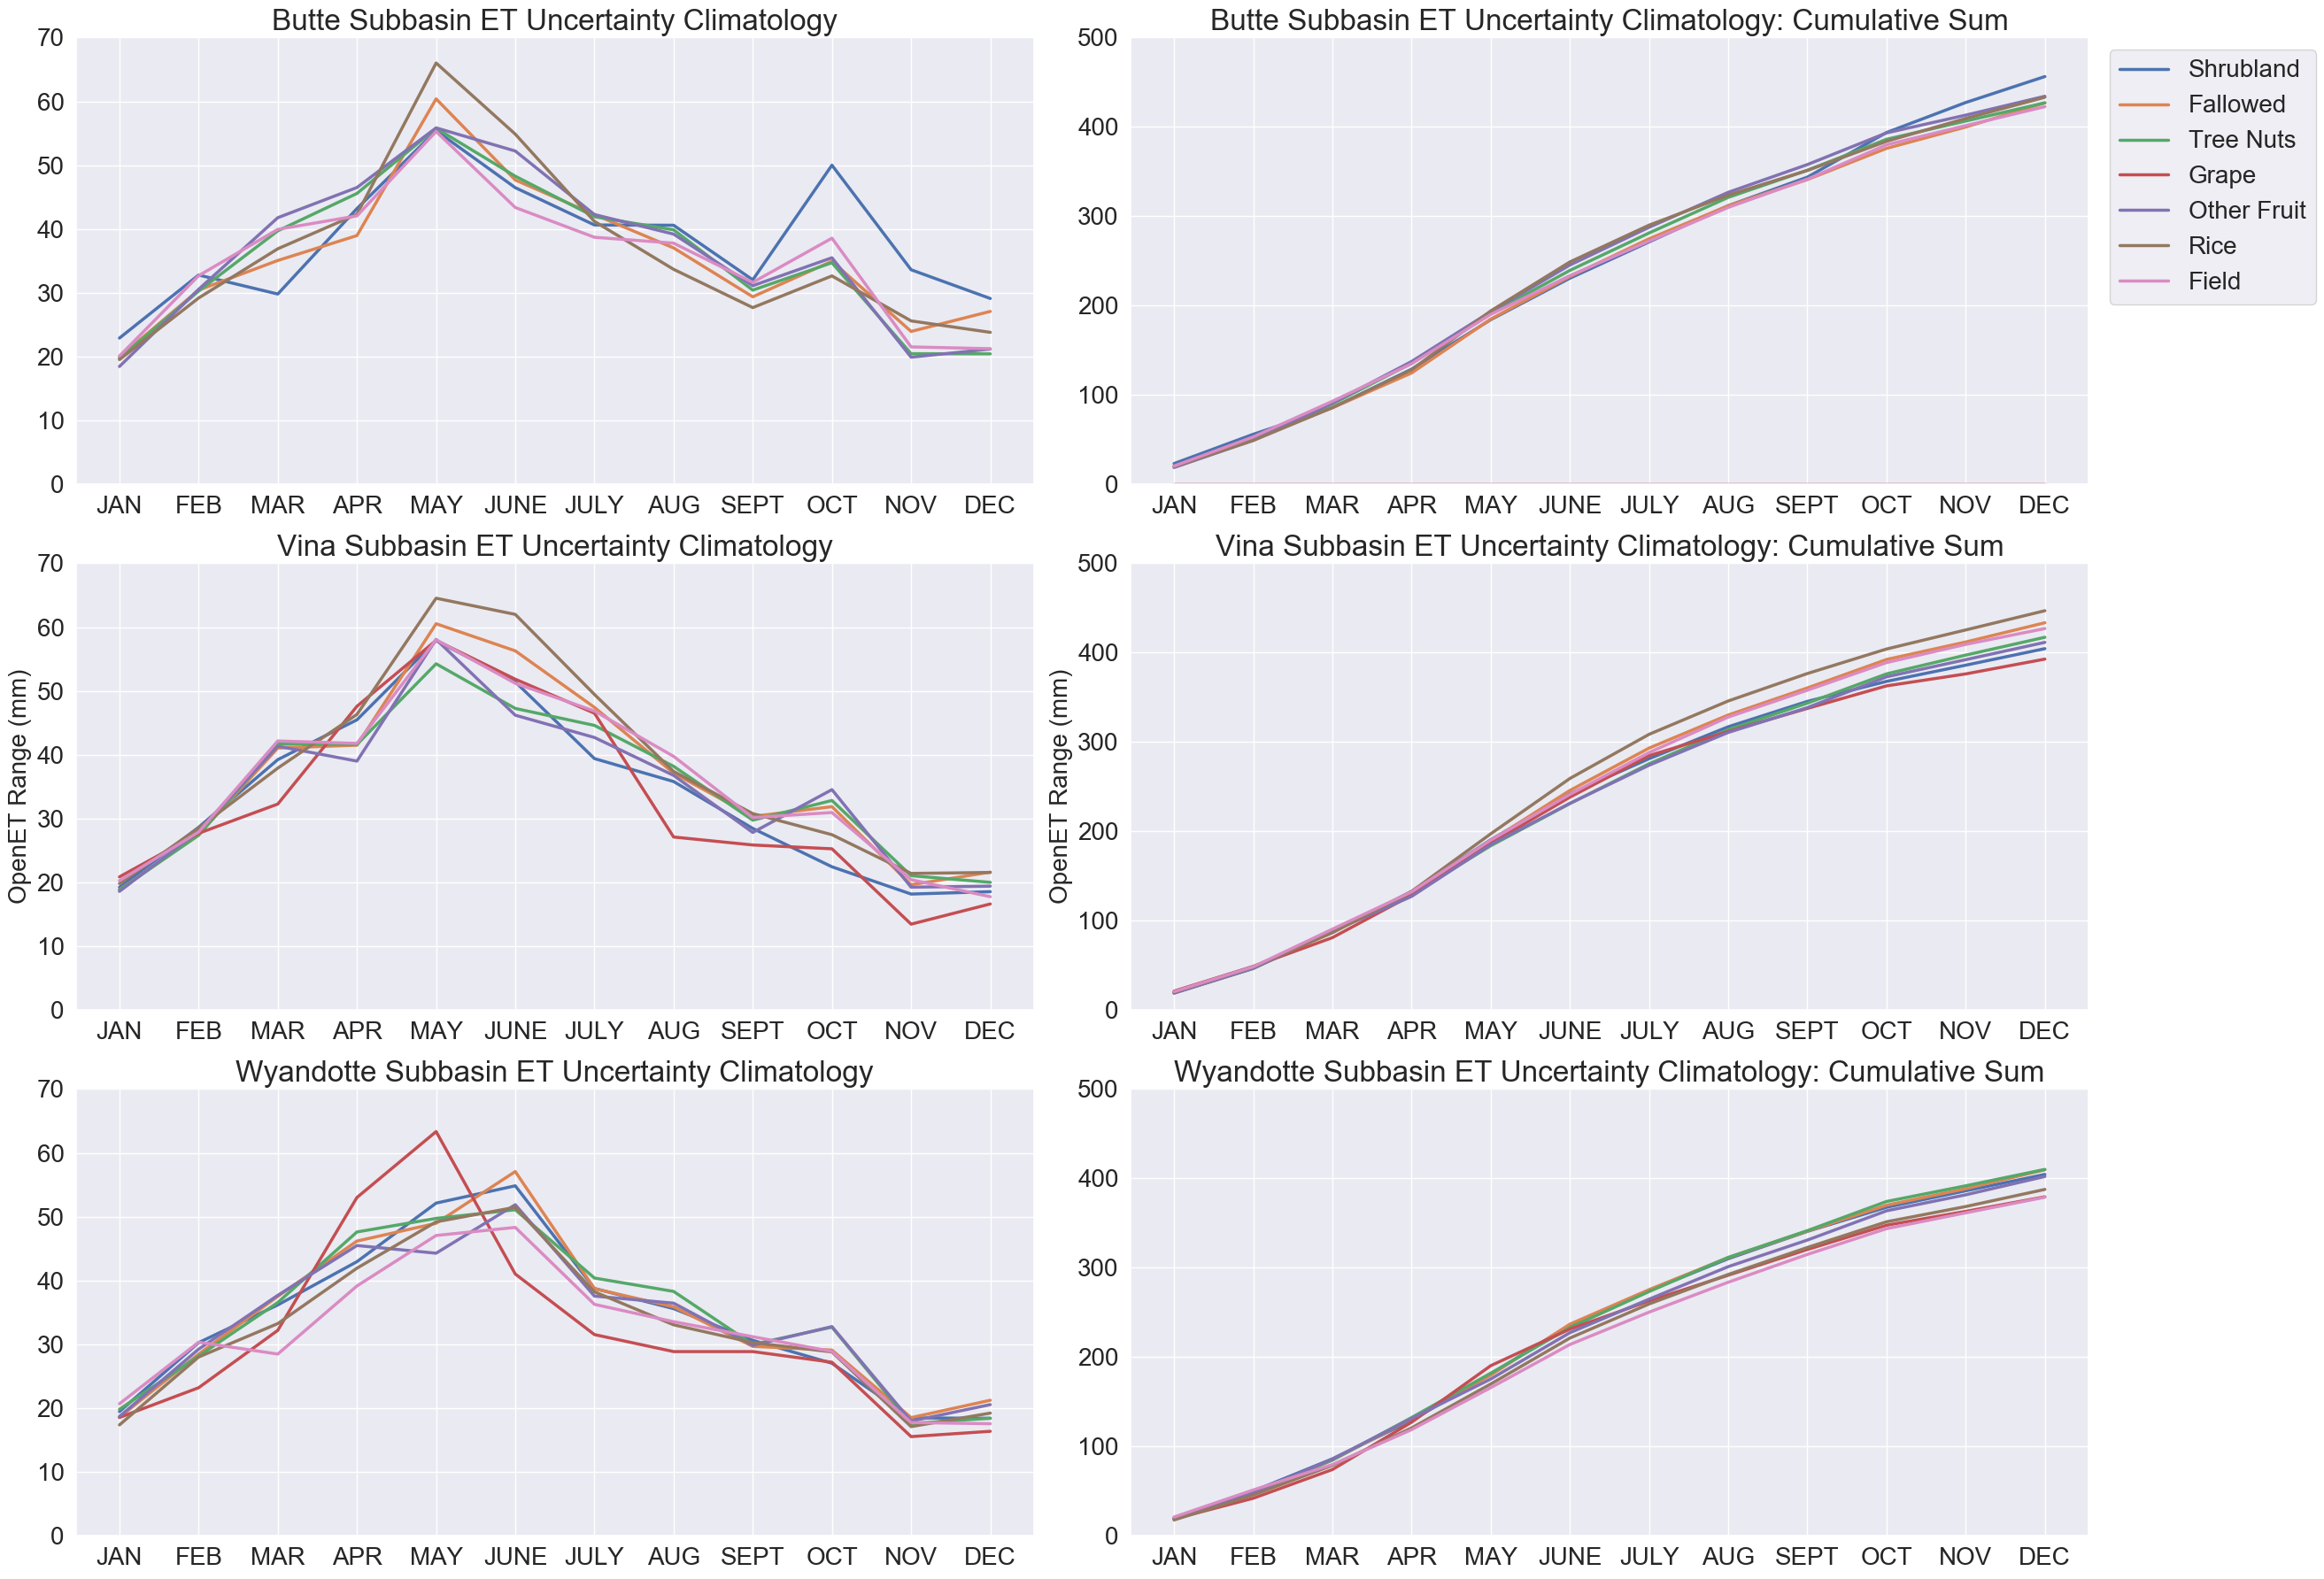

In [231]:
plot_climatologies_range(butte_results_all_clim, vina_results_all_clim, wyandotte_results_all_clim)

In [119]:
def plot_climatologies_crop(butte_dataframe, vina_dataframe, wyandotte_dataframe):
    '''plot climatologies
    Plot monthly, find where maximum for rice vs. shrubland is. When is it peaking? Why is shrubland so high?
    
    Have insitu ET estimate, have 6 openET models, what is the level of agreement at pixel, pixel+neighbors, at basin
    
    Is OpenET acceptable at basin scale vs field scale?
    
    Variance of OpenET pixels within one pixel, pixel+neighbors, at basin
    
    Recalculate error with flux tower as more models are added.
    '''
    
    x_data = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUNE',
              'JULY', 'AUG', 'SEPT', 'OCT',
              'NOV', 'DEC']
    fig, axes = plt.subplots(3,2,figsize=(24, 18))
    axes[0,0].plot(x_data, butte_dataframe['tree']['DisALEXI_ET'], label='DisALEXI')
    axes[0,0].plot(x_data, butte_dataframe['tree']['PT-JPL_ET'], label='PT-JPL')
    axes[0,0].plot(x_data, butte_dataframe['tree']['SIMS_ET'], label='SIMS')
    axes[0,0].plot(x_data, butte_dataframe['tree']['SSEBop_ET'], label='SEEBop')
    axes[0,0].plot(x_data, butte_dataframe['tree']['eeMETRIC_ET'], label='eeMETRIC')
    axes[0,0].plot(x_data, butte_dataframe['tree']['geeSEBAL_ET'], label='geeSEBAL')
    
    axes[0,0].tick_params(axis='both', labelsize=20)
    axes[0,0].set_title('Butte Subbasin ET Climatology: Tree Nuts', fontsize=24)
    axes[0,0].legend(fontsize=14)
    
    axes[0,1].plot(x_data, butte_dataframe['fallowed']['DisALEXI_ET'], label='DisALEXI')
    axes[0,1].plot(x_data, butte_dataframe['fallowed']['PT-JPL_ET'], label='PT-JPL')
    axes[0,1].plot(x_data, butte_dataframe['fallowed']['SIMS_ET'], label='SIMS')
    axes[0,1].plot(x_data, butte_dataframe['fallowed']['SSEBop_ET'], label='SEEBop')
    axes[0,1].plot(x_data, butte_dataframe['fallowed']['eeMETRIC_ET'], label='eeMETRIC')
    axes[0,1].plot(x_data, butte_dataframe['fallowed']['geeSEBAL_ET'], label='geeSEBAL')
     
    axes[0,1].tick_params(axis='both', labelsize=20)
    axes[0,1].set_title('Butte Subbasin ET Climatology: Fallowed', fontsize=24)
    
    axes[1,0].plot(x_data, vina_dataframe['tree']['DisALEXI_ET'], label='DisALEXI')
    axes[1,0].plot(x_data, vina_dataframe['tree']['PT-JPL_ET'], label='PT-JPL')
    axes[1,0].plot(x_data, vina_dataframe['tree']['SIMS_ET'], label='SIMS')
    axes[1,0].plot(x_data, vina_dataframe['tree']['SSEBop_ET'], label='SEEBop')
    axes[1,0].plot(x_data, vina_dataframe['tree']['eeMETRIC_ET'], label='eeMETRIC')
    axes[1,0].plot(x_data, vina_dataframe['tree']['geeSEBAL_ET'], label='geeSEBAL')
    
    axes[1,0].tick_params(axis='both', labelsize=20)
    axes[1,0].set_ylabel('Evapotranspiration (mm)', fontsize=20)
    axes[1,0].set_title('Vina Subbasin ET Climatology: Tree Nuts', fontsize=24)
    
    axes[1,1].plot(x_data, vina_dataframe['fallowed']['DisALEXI_ET'], label='DisALEXI')
    axes[1,1].plot(x_data, vina_dataframe['fallowed']['PT-JPL_ET'], label='PT-JPL')
    axes[1,1].plot(x_data, vina_dataframe['fallowed']['SIMS_ET'], label='SIMS')
    axes[1,1].plot(x_data, vina_dataframe['fallowed']['SSEBop_ET'], label='SEEBop')
    axes[1,1].plot(x_data, vina_dataframe['fallowed']['eeMETRIC_ET'], label='eeMETRIC')
    axes[1,1].plot(x_data, vina_dataframe['fallowed']['geeSEBAL_ET'], label='geeSEBAL')
     
    axes[1,1].tick_params(axis='both', labelsize=20)
    axes[1,1].set_ylabel('Evapotranspiration (mm)', fontsize=20)
    axes[1,1].set_title('Vina Subbasin ET Climatology: Fallowed', fontsize=24)
    
    axes[2,0].plot(x_data, wyandotte_dataframe['tree']['DisALEXI_ET'], label='DisALEXI')
    axes[2,0].plot(x_data, wyandotte_dataframe['tree']['PT-JPL_ET'], label='PT-JPL')
    axes[2,0].plot(x_data, wyandotte_dataframe['tree']['SIMS_ET'], label='SIMS')
    axes[2,0].plot(x_data, wyandotte_dataframe['tree']['SSEBop_ET'], label='SEEBop')
    axes[2,0].plot(x_data, wyandotte_dataframe['tree']['eeMETRIC_ET'], label='eeMETRIC')
    axes[2,0].plot(x_data, wyandotte_dataframe['tree']['geeSEBAL_ET'], label='geeSEBAL')
    
    axes[2,0].tick_params(axis='both', labelsize=20)
    axes[2,0].set_title('Wyandotte Subbasin ET Climatology: Tree Nuts', fontsize=24)
    
    axes[2,1].plot(x_data, wyandotte_dataframe['fallowed']['DisALEXI_ET'], label='DisALEXI')
    axes[2,1].plot(x_data, wyandotte_dataframe['fallowed']['PT-JPL_ET'], label='PT-JPL')
    axes[2,1].plot(x_data, wyandotte_dataframe['fallowed']['SIMS_ET'], label='SIMS')
    axes[2,1].plot(x_data, wyandotte_dataframe['fallowed']['SSEBop_ET'], label='SEEBop')
    axes[2,1].plot(x_data, wyandotte_dataframe['fallowed']['eeMETRIC_ET'], label='eeMETRIC')
    axes[2,1].plot(x_data, wyandotte_dataframe['fallowed']['geeSEBAL_ET'], label='geeSEBAL')
     
    axes[2,1].tick_params(axis='both', labelsize=20)
    axes[2,1].set_title('Wyandotte Subbasin ET Climatology: Fallowed', fontsize=24)
    
    plt.tight_layout()

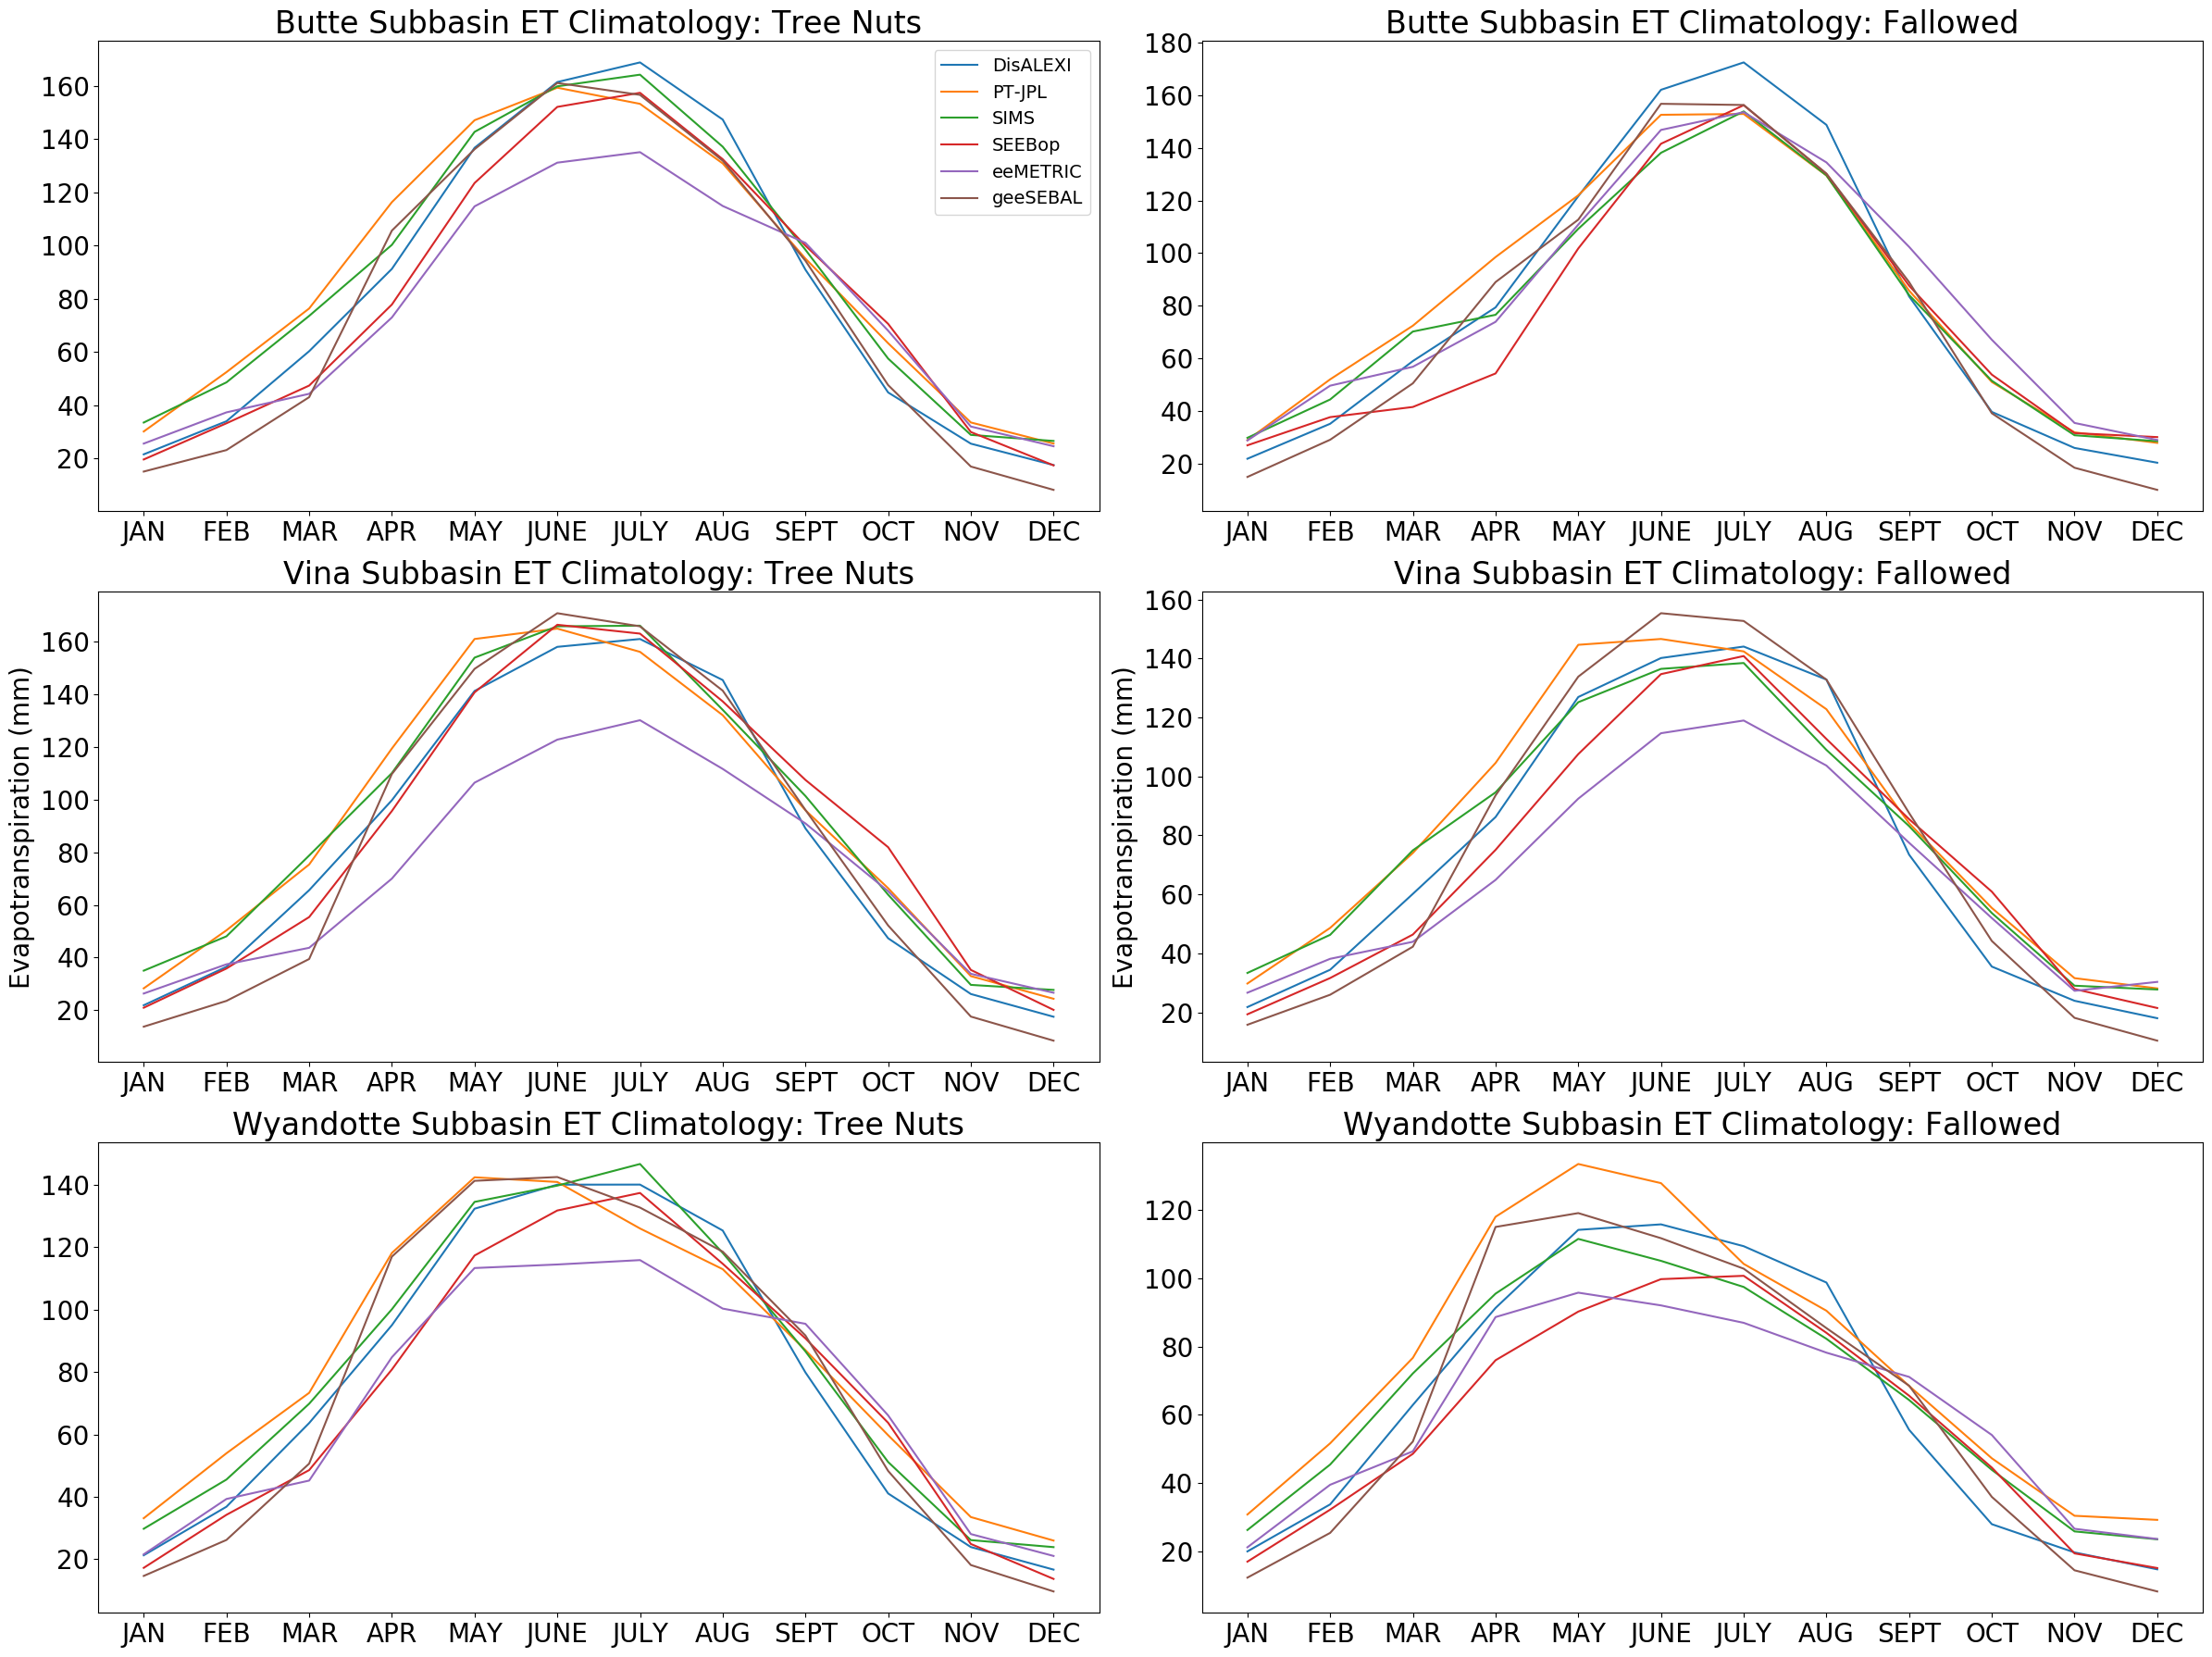

In [120]:
plot_climatologies_crop(butte_results_all_clim, vina_results_all_clim, wyandotte_results_all_clim)

In [228]:
def plot_averaged(butte_dataframe, vina_dataframe, wyandotte_dataframe):
    '''plot climatologies
    Plot monthly, find where maximum for rice vs. shrubland is. When is it peaking? Why is shrubland so high?
    
    Have insitu ET estimate, have 6 openET models, what is the level of agreement at pixel, pixel+neighbors, at basin
    
    Is OpenET acceptable at basin scale vs field scale?
    
    Variance of OpenET pixels within one pixel, pixel+neighbors, at basin
    
    Recalculate error with flux tower as more models are added.
    '''
    
    x_data = pd.date_range(start=pd.datetime(2017, 1, 1), periods=5, freq='AS')
    formatter = mdates.DateFormatter("%Y") ### formatter of the date
    locator = mdates.YearLocator() ### where to put the labels
    
    data_butte_shrubland = unpack_results('shrubland', butte_dataframe)
    data_butte_irrigated = unpack_results('irrigated', butte_dataframe)
    data_vina_shrubland = unpack_results('shrubland', vina_dataframe)
    data_vina_irrigated = unpack_results('irrigated', vina_dataframe)
    data_wyandotte_shrubland = unpack_results('shrubland', wyandotte_dataframe)
    data_wyandotte_irrigated = unpack_results('irrigated', wyandotte_dataframe)
    
    fig, axes = plt.subplots(3,2,figsize=(26, 18))
    axes[0,0].plot(x_data, data_butte_shrubland['DisALEXI_ET'], label='DisALEXI', linewidth=2.5)
    axes[0,0].plot(x_data, data_butte_shrubland['eeMETRIC_ET'], label='eeMETRIC', linewidth=2.5)
    axes[0,0].plot(x_data, data_butte_shrubland['geeSEBAL_ET'], label='geeSEBAL', linewidth=2.5)
    axes[0,0].plot(x_data, data_butte_shrubland['PT-JPL_ET'], label='PT-JPL', linewidth=2.5)
    #axes[0,0].plot(x_data, data_butte_shrubland['SIMS_ET'], label='SIMS', linewidth=2.5)
    next(axes[0,0]._get_lines.prop_cycler)
    axes[0,0].plot(x_data, data_butte_shrubland['SSEBop_ET'], label='SEEBop', linewidth=2.5)
    
    axes[0,0].tick_params(axis='both', labelsize=20)
    axes[0,0].set_title('Butte Subbasin Yearly ET: Non-irrigated', fontsize=24)
    
    axes[0,1].plot(x_data, data_butte_irrigated['DisALEXI_ET'], label='DisALEXI', linewidth=2.5)
    axes[0,1].plot(x_data, data_butte_irrigated['eeMETRIC_ET'], label='eeMETRIC', linewidth=2.5)
    axes[0,1].plot(x_data, data_butte_irrigated['geeSEBAL_ET'], label='geeSEBAL', linewidth=2.5)
    axes[0,1].plot(x_data, data_butte_irrigated['PT-JPL_ET'], label='PT-JPL', linewidth=2.5)
    axes[0,1].plot(x_data, data_butte_irrigated['SIMS_ET'], label='SIMS', linewidth=2.5)
    axes[0,1].plot(x_data, data_butte_irrigated['SSEBop_ET'], label='SEEBop', linewidth=2.5)
     
    axes[0,1].tick_params(axis='both', labelsize=20)
    axes[0,1].set_title('Butte Subbasin Yearly ET: Irrigated', fontsize=24)
    axes[0,1].legend(fontsize=20,  bbox_to_anchor=(1.25, 1))
    
    axes[1,0].plot(x_data, data_vina_shrubland['DisALEXI_ET'], label='DisALEXI', linewidth=2.5) 
    axes[1,0].plot(x_data, data_vina_shrubland['eeMETRIC_ET'], label='eeMETRIC', linewidth=2.5)
    axes[1,0].plot(x_data, data_vina_shrubland['geeSEBAL_ET'], label='geeSEBAL', linewidth=2.5)
    axes[1,0].plot(x_data, data_vina_shrubland['PT-JPL_ET'], label='PT-JPL', linewidth=2.5)
    #axes[1,0].plot(x_data, data_vina_shrubland['SIMS_ET'], label='SIMS', linewidth=2.5)
    next(axes[1,0]._get_lines.prop_cycler)
    axes[1,0].plot(x_data, data_vina_shrubland['SSEBop_ET'], label='SEEBop', linewidth=2.5)
    
    axes[1,0].tick_params(axis='both', labelsize=20)
    axes[1,0].set_ylabel('Evapotranspiration (mm)', fontsize=20)
    axes[1,0].set_title('Vina Subbasin ET Climatology: Non-irrigated', fontsize=24)
    
    axes[1,1].plot(x_data, data_vina_irrigated['DisALEXI_ET'], label='DisALEXI', linewidth=2.5)
    axes[1,1].plot(x_data, data_vina_irrigated['eeMETRIC_ET'], label='eeMETRIC', linewidth=2.5)
    axes[1,1].plot(x_data, data_vina_irrigated['geeSEBAL_ET'], label='geeSEBAL', linewidth=2.5)
    axes[1,1].plot(x_data, data_vina_irrigated['PT-JPL_ET'], label='PT-JPL', linewidth=2.5)
    axes[1,1].plot(x_data, data_vina_irrigated['SIMS_ET'], label='SIMS', linewidth=2.5)
    axes[1,1].plot(x_data, data_vina_irrigated['SSEBop_ET'], label='SEEBop', linewidth=2.5)
     
    axes[1,1].tick_params(axis='both', labelsize=20)
    axes[1,1].set_ylabel('Evapotranspiration (mm)', fontsize=20)
    axes[1,1].set_title('Vina Subbasin Yearly ET: Irrigated', fontsize=24)
    
    axes[2,0].plot(x_data, data_wyandotte_shrubland['DisALEXI_ET'], label='DisALEXI', linewidth=2.5)
    axes[2,0].plot(x_data, data_wyandotte_shrubland['eeMETRIC_ET'], label='eeMETRIC', linewidth=2.5)
    axes[2,0].plot(x_data, data_wyandotte_shrubland['geeSEBAL_ET'], label='geeSEBAL', linewidth=2.5)
    axes[2,0].plot(x_data, data_wyandotte_shrubland['PT-JPL_ET'], label='PT-JPL', linewidth=2.5)
    #axes[2,0].plot(x_data, data_wyandotte_shrubland['SIMS_ET'], label='SIMS', linewidth=2.5)
    next(axes[1,0]._get_lines.prop_cycler)
    axes[2,0].plot(x_data, data_wyandotte_shrubland['SSEBop_ET'], label='SEEBop', linewidth=2.5)
    
    axes[2,0].tick_params(axis='both', labelsize=20)
    axes[2,0].set_xlabel('Water Year', fontsize=20)
    axes[2,0].set_title('Wyandotte Subbasin Yearly ET: Non-irrigated', fontsize=24)
    
    axes[2,1].plot(x_data, data_wyandotte_irrigated['DisALEXI_ET'], label='DisALEXI', linewidth=2.5)
    axes[2,1].plot(x_data, data_wyandotte_irrigated['eeMETRIC_ET'], label='eeMETRIC', linewidth=2.5)
    axes[2,1].plot(x_data, data_wyandotte_irrigated['geeSEBAL_ET'], label='geeSEBAL', linewidth=2.5)
    axes[2,1].plot(x_data, data_wyandotte_irrigated['PT-JPL_ET'], label='PT-JPL', linewidth=2.5)
    #axes[2,1].plot(x_data, data_wyandotte_irrigated['SIMS_ET'], label='SIMS', linewidth=2.5)
    next(axes[1,0]._get_lines.prop_cycler)
    axes[2,1].plot(x_data, data_wyandotte_irrigated['SSEBop_ET'], label='SEEBop', linewidth=2.5)
     
    axes[2,1].tick_params(axis='both', labelsize=20)
    axes[2,1].set_xlabel('Water Year', fontsize=20)
    axes[2,1].set_title('Wyandotte Subbasin Yearly ET: Irrigated', fontsize=24)
    
    axes[0,0].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[0,0].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[0,1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[0,1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[1,0].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[1,0].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[1,1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[1,1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[2,0].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[2,0].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[2,1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[2,1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    
    plt.tight_layout()

/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


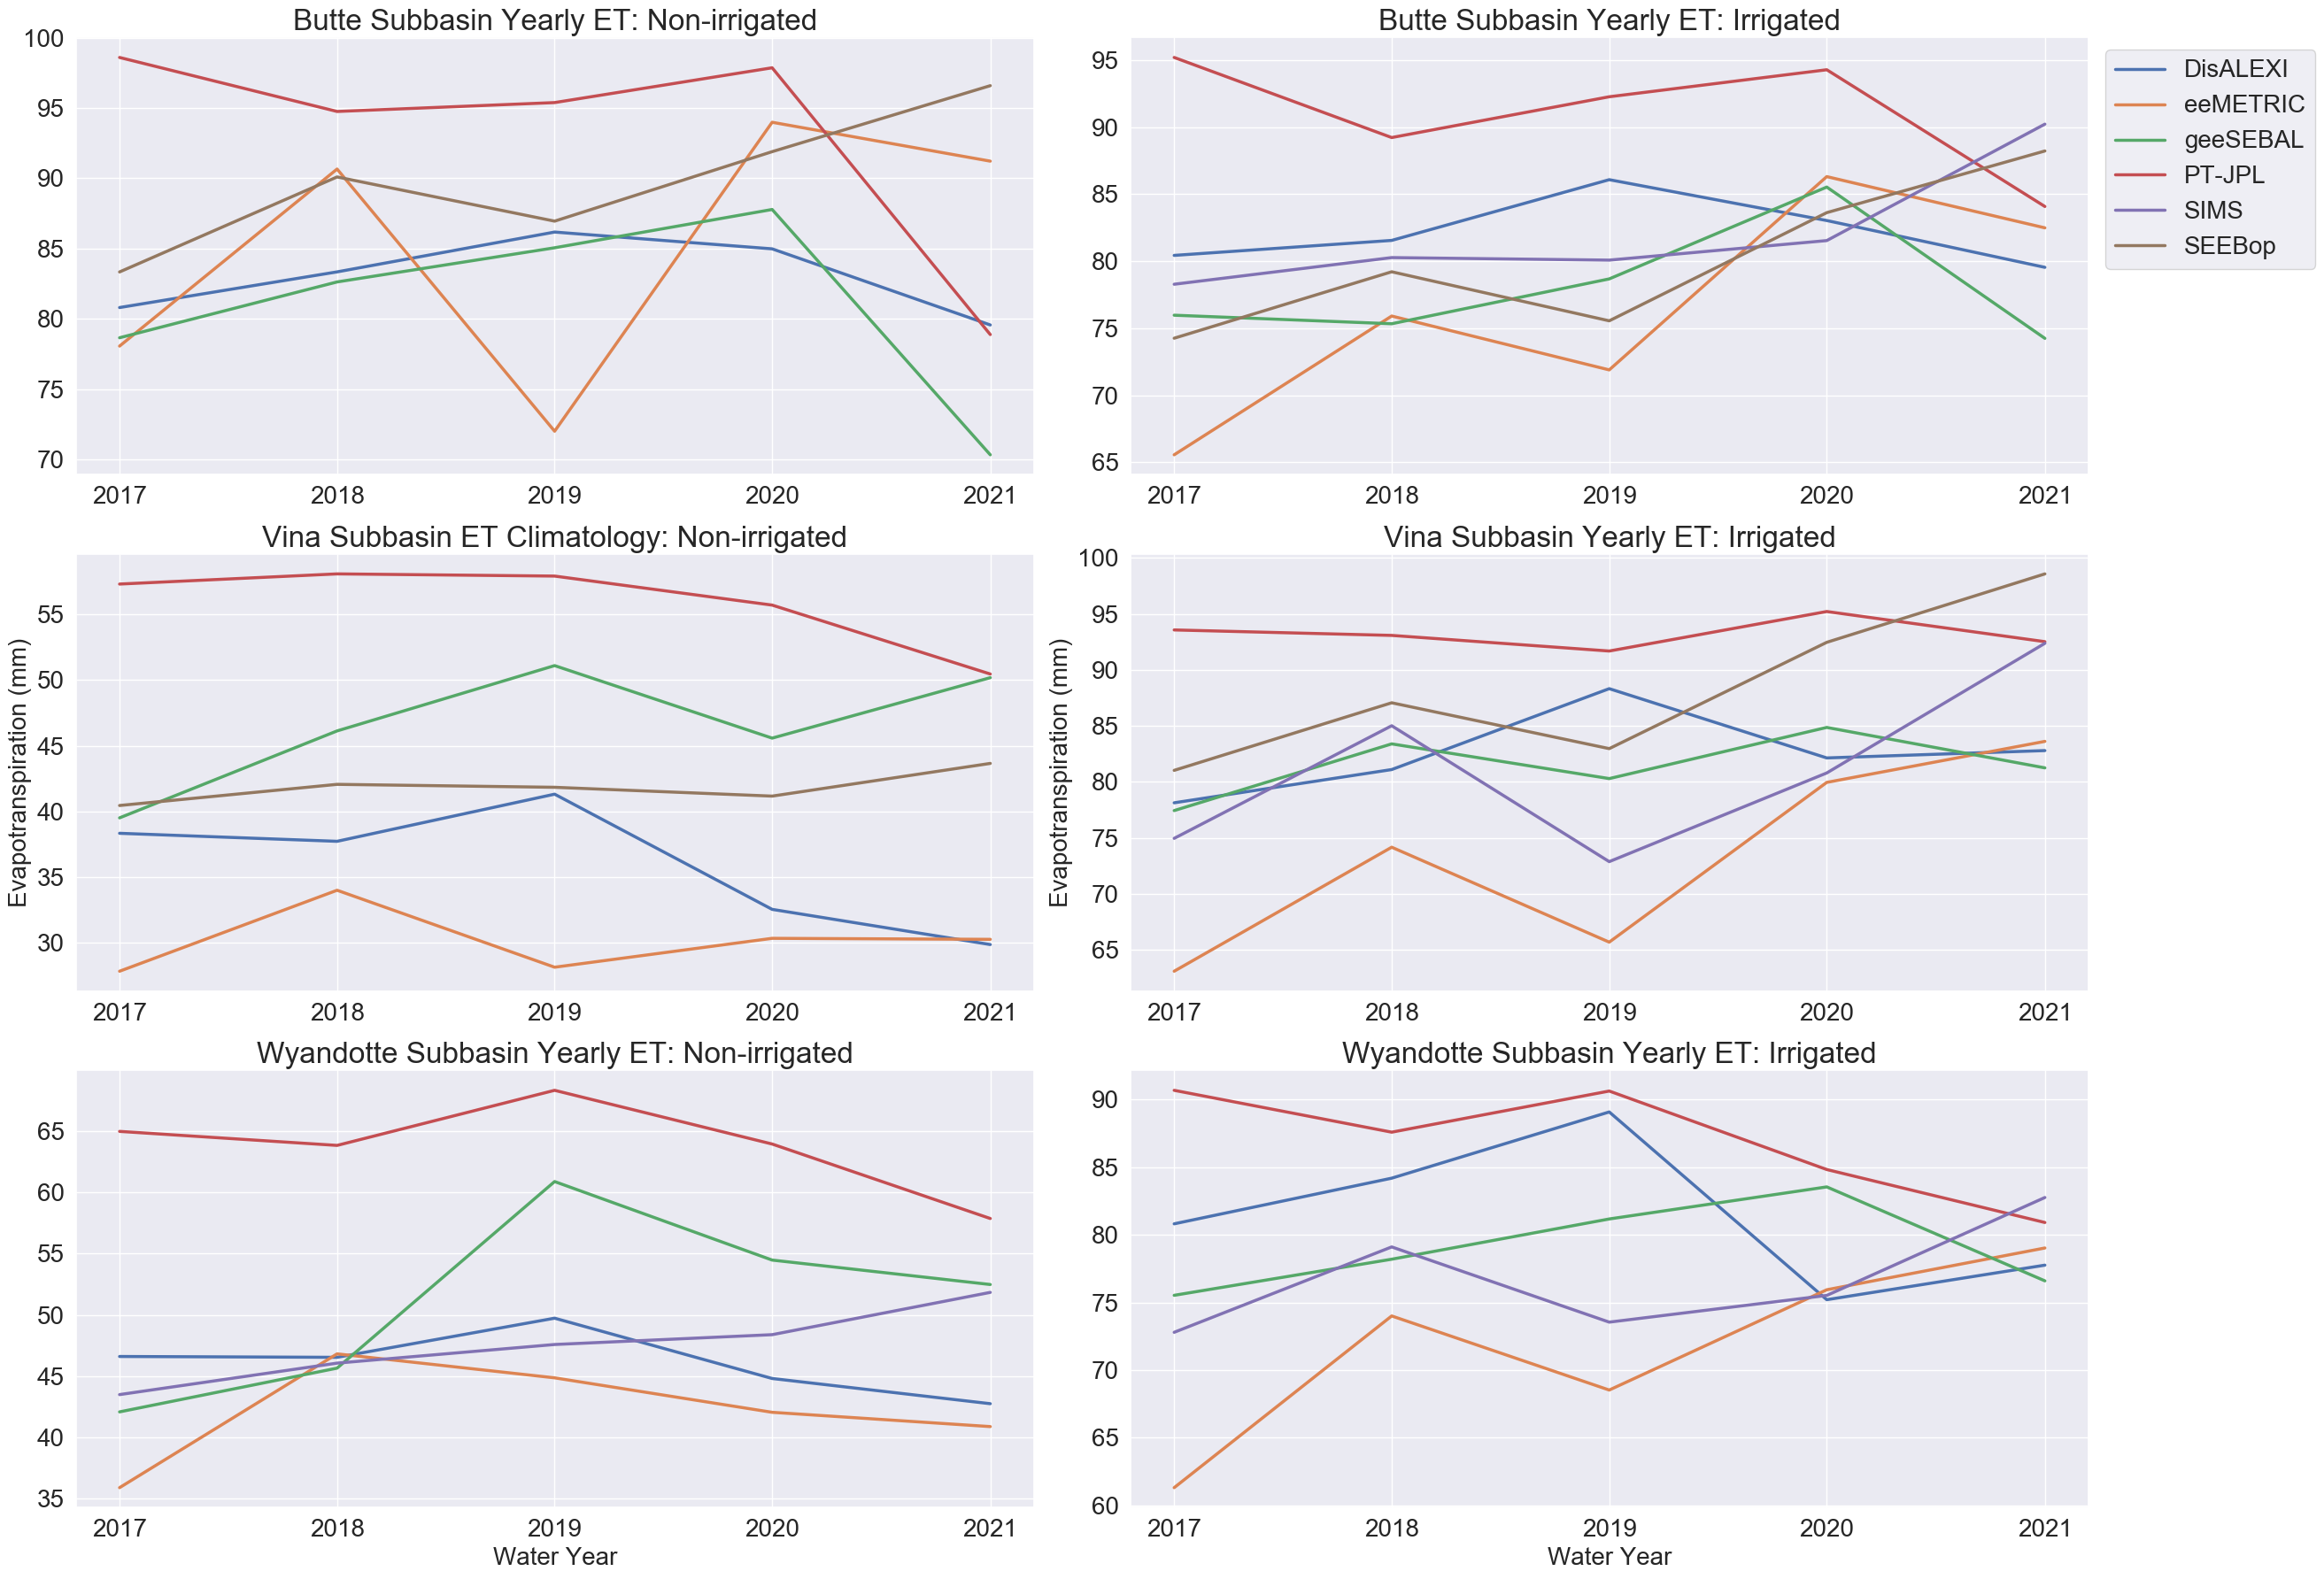

In [229]:
plot_averaged(butte_results_irrigated_avg, vina_results_irrigated_avg, wyandotte_results_irrigated_avg)

In [54]:
def average_dict(data_dict):
    data_dict['DisALEXI_ET'] = data_dict['DisALEXI_ET'] - np.mean(data_dict['DisALEXI_ET'])
    data_dict['PT-JPL_ET'] = data_dict['PT-JPL_ET'] - np.mean(data_dict['PT-JPL_ET'])
    data_dict['SIMS_ET'] = data_dict['SIMS_ET'] - np.mean(data_dict['SIMS_ET'])
    data_dict['SSEBop_ET'] = data_dict['SSEBop_ET'] - np.mean(data_dict['SSEBop_ET'])
    data_dict['eeMETRIC_ET'] = data_dict['eeMETRIC_ET'] - np.mean(data_dict['eeMETRIC_ET'])
    data_dict['geeSEBAL_ET'] = data_dict['geeSEBAL_ET'] - np.mean(data_dict['geeSEBAL_ET'])
    
    return data_dict
    

In [147]:
def plot_averaged_normalized(butte_dataframe, vina_dataframe, wyandotte_dataframe):
    '''plot climatologies
    Plot monthly, find where maximum for rice vs. shrubland is. When is it peaking? Why is shrubland so high?
    
    Have insitu ET estimate, have 6 openET models, what is the level of agreement at pixel, pixel+neighbors, at basin
    
    Is OpenET acceptable at basin scale vs field scale?
    
    Variance of OpenET pixels within one pixel, pixel+neighbors, at basin
    
    Recalculate error with flux tower as more models are added.
    '''
    
    x_data = pd.date_range(start=pd.datetime(2017, 1, 1), periods=5, freq='AS')
    formatter = mdates.DateFormatter("%Y") ### formatter of the date
    locator = mdates.YearLocator() ### where to put the labels
    
    data_butte_shrubland = unpack_results('shrubland', butte_dataframe)
    data_butte_irrigated = unpack_results('irrigated', butte_dataframe)
    data_vina_shrubland = unpack_results('shrubland', vina_dataframe)
    data_vina_irrigated = unpack_results('irrigated', vina_dataframe)
    data_wyandotte_shrubland = unpack_results('shrubland', wyandotte_dataframe)
    data_wyandotte_irrigated = unpack_results('irrigated', wyandotte_dataframe)
    
    data_butte_shrubland = average_dict(data_butte_shrubland)
    data_butte_irrigated = average_dict(data_butte_irrigated)
    data_vina_shrubland = average_dict(data_vina_shrubland)
    data_vina_irrigated = average_dict(data_vina_irrigated)
    data_wyandotte_shrubland = average_dict(data_wyandotte_shrubland)
    data_wyandotte_irrigated = average_dict(data_wyandotte_irrigated)
    
    fig, axes = plt.subplots(3,2,figsize=(24, 18))
    axes[0,0].plot(x_data, data_butte_shrubland['DisALEXI_ET'], label='DisALEXI')
    axes[0,0].plot(x_data, data_butte_shrubland['eeMETRIC_ET'], label='eeMETRIC')
    axes[0,0].plot(x_data, data_butte_shrubland['geeSEBAL_ET'], label='geeSEBAL')
    axes[0,0].plot(x_data, data_butte_shrubland['PT-JPL_ET'], label='PT-JPL')
    #axes[0,0].plot(x_data, data_butte_shrubland['SIMS_ET'], label='SIMS')
    next(axes[0,0]._get_lines.prop_cycler)
    axes[0,0].plot(x_data, data_butte_shrubland['SSEBop_ET'], label='SSEBop')

    #axes_00_twinx = axes[0,0].twinx()
    #axes_00_twinx.plot(x_data, precip_butte_yearly['average'][-5:]/area_bs_km2*1e6, linestyle='-', color='blue', linewidth=2)
    
    
    
    axes[0,0].tick_params(axis='both', labelsize=20)
    axes[0,0].set_title('Butte Subbasin ET: Non-Irrigated', fontsize=24)
    axes[0,0].yaxis.grid(False)
    #axes_00_twinx.tick_params(axis='both', labelsize=20)
    #axes_00_twinx.yaxis.grid(False)
    
    
    plt.tight_layout()
    axes[0,1].plot(x_data, data_butte_irrigated['DisALEXI_ET'], label='DisALEXI')
    axes[0,1].plot(x_data, data_butte_irrigated['eeMETRIC_ET'], label='eeMETRIC')
    axes[0,1].plot(x_data, data_butte_irrigated['geeSEBAL_ET'], label='geeSEBAL')
    axes[0,1].plot(x_data, data_butte_irrigated['PT-JPL_ET'], label='PT-JPL')
    axes[0,1].plot(x_data, data_butte_irrigated['SIMS_ET'], label='SIMS')
    axes[0,1].plot(x_data, data_butte_irrigated['SSEBop_ET'], label='SEEBop')

    #axes_01_twinx = axes[0,1].twinx()
    #axes_01_twinx.plot(x_data, precip_butte_yearly['average'][-5:]/area_bs_km2*1e6, linestyle='-', color='blue', linewidth=2,
   #                   label='Average Preciptiation')
    
    axes[0,1].legend(fontsize=14, loc='lower left')
    axes[0,1].tick_params(axis='both', labelsize=20)
    axes[0,1].set_title('Butte Subbasin ET: Irrigated', fontsize=24)
    axes[0,1].yaxis.grid(False)
    #axes_01_twinx.tick_params(axis='both', labelsize=20)
    #axes_01_twinx.yaxis.grid(False)
    #axes_01_twinx.legend(fontsize=14, loc='lower right')
    
    
    
    axes[1,0].plot(x_data, data_vina_shrubland['DisALEXI_ET'], label='DisALEXI')
    axes[1,0].plot(x_data, data_vina_shrubland['eeMETRIC_ET'], label='eeMETRIC')
    axes[1,0].plot(x_data, data_vina_shrubland['geeSEBAL_ET'], label='geeSEBAL')
    axes[1,0].plot(x_data, data_vina_shrubland['PT-JPL_ET'], label='PT-JPL')
    #axes[1,0].plot(x_data, data_vina_shrubland['SIMS_ET'], label='SIMS')
    next(axes[1,0]._get_lines.prop_cycler)
    axes[1,0].plot(x_data, data_vina_shrubland['SSEBop_ET'], label='SSEBop')

    #axes_10_twinx = axes[1,0].twinx()
    #axes_10_twinx.plot(x_data, precip_vina_yearly['average'][-5:]/area_vs_km2*1e6, linestyle='-', color='blue', linewidth=2)
    
    
    axes[1,0].tick_params(axis='both', labelsize=20)
    axes[1,0].set_ylabel('Mean-Centered Evapotranspiration (mm)', fontsize=20)
    axes[1,0].set_title('Vina Subbasin ET: Non-Irrigated', fontsize=24)
    axes[1,0].yaxis.grid(False)
    #axes_10_twinx.tick_params(axis='both', labelsize=20)
    #axes_10_twinx.yaxis.grid(False)
    
    axes[1,1].plot(x_data, data_vina_irrigated['DisALEXI_ET'], label='DisALEXI')
    axes[1,1].plot(x_data, data_vina_irrigated['eeMETRIC_ET'], label='eeMETRIC')
    axes[1,1].plot(x_data, data_vina_irrigated['geeSEBAL_ET'], label='geeSEBAL')
    axes[1,1].plot(x_data, data_vina_irrigated['PT-JPL_ET'], label='PT-JPL')
    axes[1,1].plot(x_data, data_vina_irrigated['SIMS_ET'], label='SIMS')
    axes[1,1].plot(x_data, data_vina_irrigated['SSEBop_ET'], label='SSEBop')

    #axes_11_twinx = axes[1,1].twinx()
    #axes_11_twinx.plot(x_data, precip_vina_yearly['average'][-5:]/area_vs_km2*1e6, linestyle='-', color='blue', linewidth=2)
     
    axes[1,1].tick_params(axis='both', labelsize=20)
    axes[1,1].set_title('Vina Subbasin ET: Irrigated', fontsize=24)
    axes[1,1].yaxis.grid(False)
    #axes_11_twinx.set_ylabel('Annual Mean Subbasin Precipitation (mm)', fontsize=20)
    #axes_11_twinx.tick_params(axis='both', labelsize=20)
    #axes_11_twinx.yaxis.grid(False)
    
    #axes_20_twinx = axes[2,0].twinx()
    #axes_20_twinx.plot(x_data, precip_wyandotte_yearly['average'][-5:]/area_ws_km2*1e6, linestyle='-', color='blue', linewidth=2, zorder=-10)
    axes[2,0].plot(x_data, data_wyandotte_shrubland['DisALEXI_ET'], label='DisALEXI')
    axes[2,0].plot(x_data, data_wyandotte_shrubland['eeMETRIC_ET'], label='eeMETRIC')
    axes[2,0].plot(x_data, data_wyandotte_shrubland['geeSEBAL_ET'], label='geeSEBAL')
    axes[2,0].plot(x_data, data_wyandotte_shrubland['PT-JPL_ET'], label='PT-JPL')
    #axes[2,0].plot(x_data, data_butte_shrubland['SIMS_ET'], label='SIMS')
    next(axes[2,0]._get_lines.prop_cycler)
    axes[2,0].plot(x_data, data_wyandotte_shrubland['SSEBop_ET'], label='SSEBop')
    
    
    
    axes[2,0].tick_params(axis='both', labelsize=20)
    axes[2,0].set_xlabel('Water Year', fontsize=20)
    axes[2,0].yaxis.grid(False)
    #axes_20_twinx.tick_params(axis='both', labelsize=20)
    #axes_20_twinx.yaxis.grid(False)
    
    axes[2,0].set_title('Wyandotte Subbasin ET: Non-Irrigated', fontsize=24)
    
    #axes_21_twinx = axes[2,1].twinx()
    #axes_21_twinx.plot(x_data, precip_wyandotte_yearly['average'][-5:]/area_ws_km2*1e6, linestyle='-', color='blue', linewidth=2)
    #axes_21_twinx.plot(x_data, pet_wyandotte_yearly[-5:]/area_ws_km2*1e6, linestyle='-', color='green', linewidth=2)
    axes[2,1].plot(x_data, data_wyandotte_irrigated['DisALEXI_ET'], label='DisALEXI')
    axes[2,1].plot(x_data, data_wyandotte_irrigated['eeMETRIC_ET'], label='eeMETRIC')
    axes[2,1].plot(x_data, data_wyandotte_irrigated['geeSEBAL_ET'], label='geeSEBAL')
    axes[2,1].plot(x_data, data_wyandotte_irrigated['PT-JPL_ET'], label='PT-JPL')
    axes[2,1].plot(x_data, data_wyandotte_irrigated['SIMS_ET'], label='SIMS')
    axes[2,1].plot(x_data, data_wyandotte_irrigated['SSEBop_ET'], label='SSEBop')
    
    
     
    axes[2,1].tick_params(axis='both', labelsize=20)
    axes[2,1].set_xlabel('Water Year', fontsize=20)
    axes[2,1].yaxis.grid(False)
    #axes_21_twinx.tick_params(axis='both', labelsize=20)
    #axes_21_twinx.yaxis.grid(False)

    axes[2,1].set_title('Wyandotte Subbasin ET: Irrigated', fontsize=24)
    plt.tight_layout()
    axes[0,0].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[0,0].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[0,1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[0,1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[1,0].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[1,0].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[1,1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[1,1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[2,0].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[2,0].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[2,1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[2,1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    
    plt.tight_layout()

In [148]:
plot_averaged_normalized(butte_results_irrigated_avg, vina_results_irrigated_avg, wyandotte_results_irrigated_avg)

/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


In [150]:
def compute_cosine_sim(avg_dict):
    cosine_sim_matrix = np.zeros((6,6))
    key_list = ['DisALEXI_ET', 'eeMETRIC_ET', 'geeSEBAL_ET', 'PT-JPL_ET', 'SIMS_ET', 'SSEBop_ET']
    for i in range(6):
        for j in range(6):
            cosine_sim_matrix[i,j] = dot(avg_dict[key_list[i]], avg_dict[key_list[j]]) / (
                norm(avg_dict[key_list[i]])*norm(avg_dict[key_list[j]]))
    return cosine_sim_matrix

def compute_corr_coef(avg_dict):
    corr_coef_matrix = np.zeros((6,6))
    key_list = ['DisALEXI_ET', 'PT-JPL_ET', 'SIMS_ET', 'SSEBop_ET', 'eeMETRIC_ET', 'geeSEBAL_ET']
    for i in range(6):
        for j in range(6):
            corr_coef_matrix[i,j] = np.corrcoef(avg_dict[key_list[i]], avg_dict[key_list[j]])[0,1]
    return corr_coef_matrix

In [220]:
def cosine_sim_plot(butte_dataframe, vina_dataframe, wyandotte_dataframe):
    label_list = [0, 'DisALEXI', 'eeMETRIC', 'geeSEBAL', 'PT-JPL', 'SIMS', 'SSEBop']
    data_butte_shrubland = unpack_results('shrubland', butte_dataframe)
    data_butte_irrigated = unpack_results('irrigated', butte_dataframe)
    data_vina_shrubland = unpack_results('shrubland', vina_dataframe)
    data_vina_irrigated = unpack_results('irrigated', vina_dataframe)
    data_wyandotte_shrubland = unpack_results('shrubland', wyandotte_dataframe)
    data_wyandotte_irrigated = unpack_results('irrigated', wyandotte_dataframe)

    data_butte_shrubland = average_dict(data_butte_shrubland)
    data_butte_irrigated = average_dict(data_butte_irrigated)
    data_vina_shrubland = average_dict(data_vina_shrubland)
    data_vina_irrigated = average_dict(data_vina_irrigated)
    data_wyandotte_shrubland = average_dict(data_wyandotte_shrubland)
    data_wyandotte_irrigated = average_dict(data_wyandotte_irrigated)
    
    butte_shrubland_cosine = compute_cosine_sim(data_butte_shrubland)
    butte_irrigated_cosine = compute_cosine_sim(data_butte_irrigated)
    vina_shrubland_cosine = compute_cosine_sim(data_vina_shrubland)
    vina_irrigated_cosine = compute_cosine_sim(data_vina_irrigated)
    wyandotte_shrubland_cosine = compute_cosine_sim(data_wyandotte_shrubland)
    wyandotte_irrigated_cosine = compute_cosine_sim(data_wyandotte_irrigated)
    
    fig, axes = plt.subplots(3,2,figsize=(21, 21))
    im = axes[0,0].imshow(butte_shrubland_cosine, cmap='RdBu_r')
    cbar = fig.colorbar(im, ax=axes[0,0])
    cbar.set_label(label='Cosine Similarity', size=18)
    cbar.ax.tick_params(labelsize=16)
    axes[0,0].set_xticklabels(label_list)
    axes[0,0].set_yticklabels(label_list)
    axes[0,0].tick_params(axis='both', which='major', labelsize=16)
    axes[0,0].tick_params(axis='x', which='major', rotation=45)
    axes[0,0].set_title('Butte Subbasin ET: Non-Irrigated', fontsize=20)
    
    im = axes[0,1].imshow(butte_irrigated_cosine, cmap='RdBu_r')
    cbar = fig.colorbar(im, ax=axes[0,1])
    cbar.set_label(label='Cosine Similarity', size=18)
    cbar.ax.tick_params(labelsize=16)
    axes[0,1].set_xticklabels(label_list)
    axes[0,1].set_yticklabels(label_list)
    axes[0,1].tick_params(axis='both', which='major', labelsize=16)
    axes[0,1].tick_params(axis='x', which='major', rotation=45)
    axes[0,1].set_title('Butte Subbasin ET: Irrigated', fontsize=20)
    
    im = axes[1,0].imshow(vina_shrubland_cosine, cmap='RdBu_r')
    cbar = fig.colorbar(im, ax=axes[1,0])
    cbar.set_label(label='Cosine Similarity', size=18)
    cbar.ax.tick_params(labelsize=16)
    axes[1,0].set_xticklabels(label_list)
    axes[1,0].set_yticklabels(label_list)
    axes[1,0].tick_params(axis='both', which='major', labelsize=16)
    axes[1,0].tick_params(axis='x', which='major', rotation=45)
    axes[1,0].set_title('Vina Subbasin ET: Non-Irrigated', fontsize=20)
    
    im = axes[1,1].imshow(vina_irrigated_cosine, cmap='RdBu_r')
    cbar = fig.colorbar(im, ax=axes[1,1])
    cbar.set_label(label='Cosine Similarity', size=18)
    cbar.ax.tick_params(labelsize=16)
    axes[1,1].set_xticklabels(label_list)
    axes[1,1].set_yticklabels(label_list)
    axes[1,1].tick_params(axis='both', which='major', labelsize=16)
    axes[1,1].tick_params(axis='x', which='major', rotation=45)
    axes[1,1].set_title('Vina Subbasin ET: Irrigated', fontsize=20)
    
    im = axes[2,0].imshow(wyandotte_shrubland_cosine, cmap='RdBu_r')
    cbar = fig.colorbar(im, ax=axes[2,0])
    cbar.set_label(label='Cosine Similarity', size=18)
    cbar.ax.tick_params(labelsize=16)
    axes[2,0].set_xticklabels(label_list)
    axes[2,0].set_yticklabels(label_list)
    axes[2,0].tick_params(axis='both', which='major', labelsize=16)
    axes[2,0].tick_params(axis='x', which='major', rotation=45)
    axes[2,0].set_title('Wyandotte Subbasin ET: Non-Irrigated', fontsize=20)
    
    im = axes[2,1].imshow(wyandotte_irrigated_cosine, cmap='RdBu_r')
    cbar = fig.colorbar(im, ax=axes[2,1])
    cbar.set_label(label='Cosine Similarity', size=18)
    cbar.ax.tick_params(labelsize=16)
    axes[2,1].set_xticklabels(label_list)
    axes[2,1].set_yticklabels(label_list)
    axes[2,1].tick_params(axis='both', which='major', labelsize=16)
    axes[2,1].tick_params(axis='x', which='major', rotation=45)
    axes[2,1].set_title('Wyandotte Subbasin ET: Irrigated', fontsize=20)
    plt.tight_layout()
    
    print(butte_shrubland_cosine)

In [221]:
def corr_coef_plot(butte_dataframe, vina_dataframe, wyandotte_dataframe):
    data_butte_shrubland = unpack_results('shrubland', butte_dataframe)
    data_butte_irrigated = unpack_results('irrigated', butte_dataframe)
    data_vina_shrubland = unpack_results('shrubland', vina_dataframe)
    data_vina_irrigated = unpack_results('irrigated', vina_dataframe)
    data_wyandotte_shrubland = unpack_results('shrubland', wyandotte_dataframe)
    data_wyandotte_irrigated = unpack_results('irrigated', wyandotte_dataframe)

    data_butte_shrubland = average_dict(data_butte_shrubland)
    data_butte_irrigated = average_dict(data_butte_irrigated)
    data_vina_shrubland = average_dict(data_vina_shrubland)
    data_vina_irrigated = average_dict(data_vina_irrigated)
    data_wyandotte_shrubland = average_dict(data_wyandotte_shrubland)
    data_wyandotte_irrigated = average_dict(data_wyandotte_irrigated)
    
    butte_shrubland_corr = compute_corr_coef(data_butte_shrubland)
    
    print(butte_shrubland_corr)

[[ 1.         -0.25973141  0.91189014  0.6007788  -0.67373599 -0.2506314 ]
 [-0.25973141  1.         -0.12500246 -0.33454548  0.84048018  0.75185178]
 [ 0.91189014 -0.12500246  1.          0.83139559 -0.43020397 -0.39812509]
 [ 0.6007788  -0.33454548  0.83139559  1.         -0.32906041 -0.78814158]
 [-0.67373599  0.84048018 -0.43020397 -0.32906041  1.          0.49389726]
 [-0.2506314   0.75185178 -0.39812509 -0.78814158  0.49389726  1.        ]]
[[ 1.          0.6007788  -0.67373599 -0.2506314  -0.25973141  0.91189014]
 [ 0.6007788   1.         -0.32906041 -0.78814158 -0.33454548  0.83139559]
 [-0.67373599 -0.32906041  1.          0.49389726  0.84048018 -0.43020397]
 [-0.2506314  -0.78814158  0.49389726  1.          0.75185178 -0.39812509]
 [-0.25973141 -0.33454548  0.84048018  0.75185178  1.         -0.12500246]
 [ 0.91189014  0.83139559 -0.43020397 -0.39812509 -0.12500246  1.        ]]


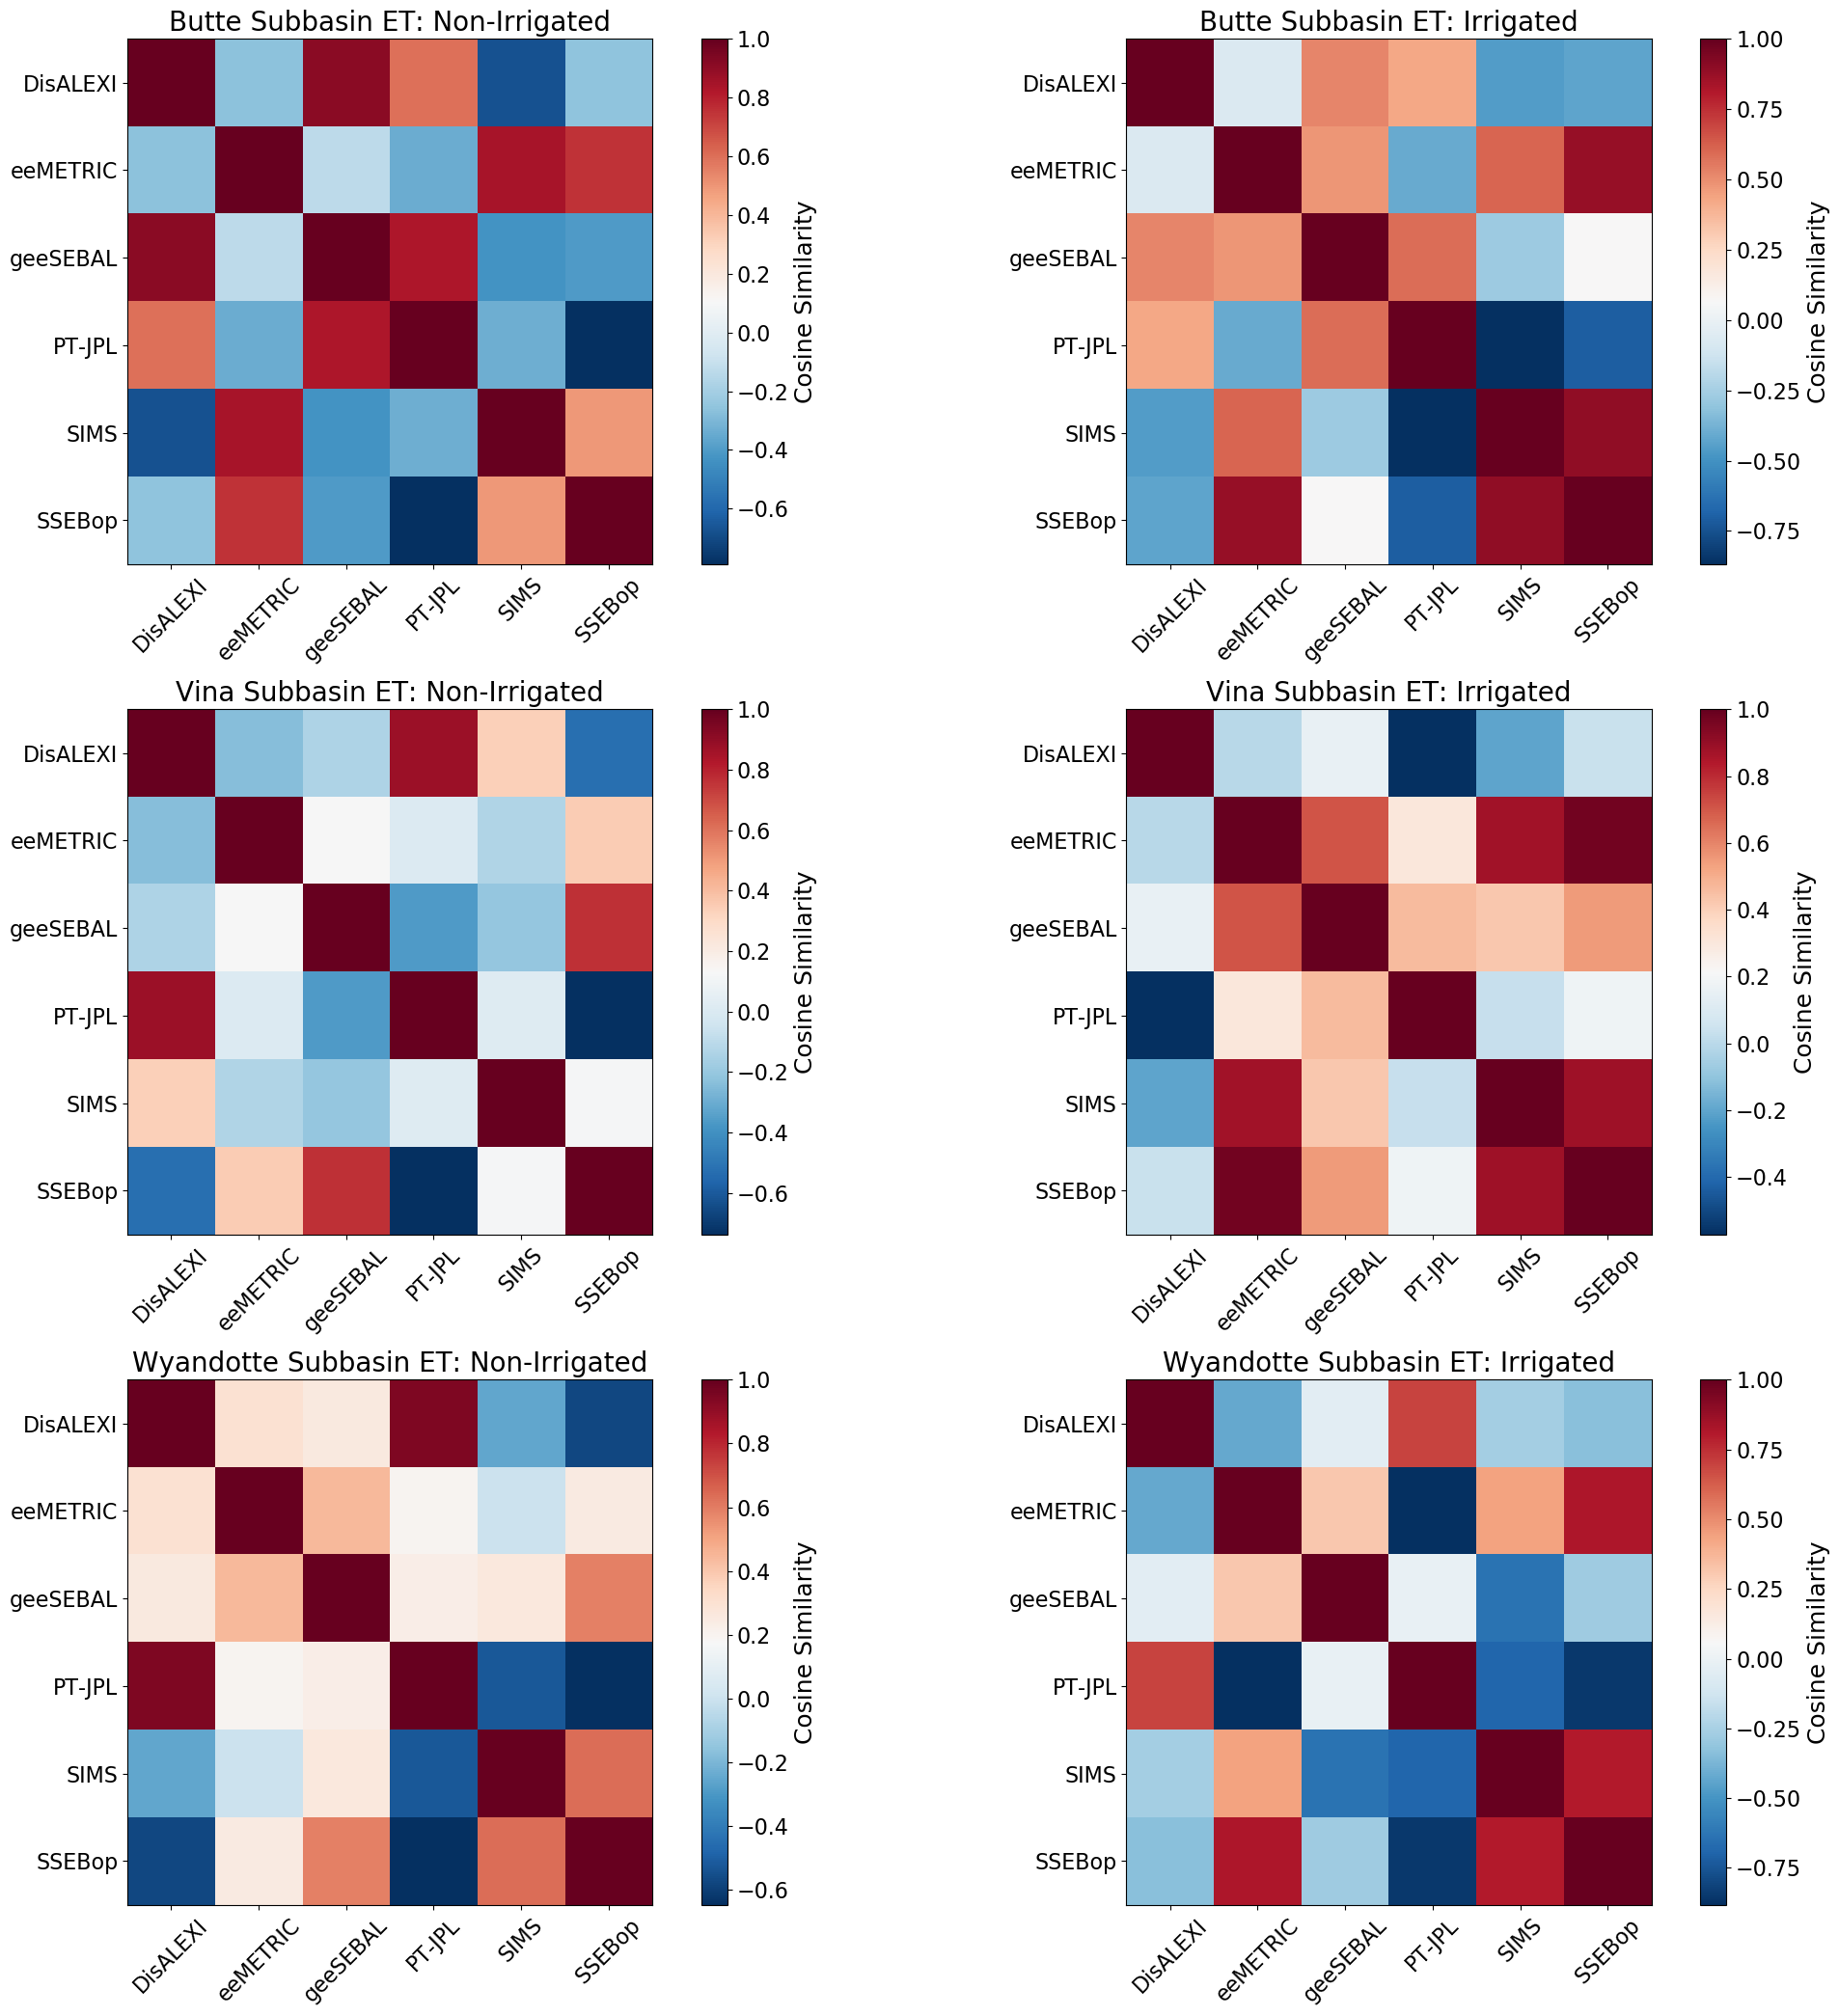

In [222]:
matplotlib.rc_file_defaults()
cosine_sim_plot(butte_results_irrigated_avg, vina_results_irrigated_avg, wyandotte_results_irrigated_avg)
corr_coef_plot(butte_results_irrigated_avg, vina_results_irrigated_avg, wyandotte_results_irrigated_avg)

In [187]:
def plot_averaged_crop(butte_dataframe, vina_dataframe, wyandotte_dataframe):
    '''plot climatologies
    Plot monthly, find where maximum for rice vs. shrubland is. When is it peaking? Why is shrubland so high?
    
    Have insitu ET estimate, have 6 openET models, what is the level of agreement at pixel, pixel+neighbors, at basin
    
    Is OpenET acceptable at basin scale vs field scale?
    
    Variance of OpenET pixels within one pixel, pixel+neighbors, at basin
    
    Recalculate error with flux tower as more models are added.
    '''
    
    x_data = pd.date_range(start=pd.datetime(2017, 1, 1), periods=5, freq='AS')
    formatter = mdates.DateFormatter("%Y") ### formatter of the date
    locator = mdates.YearLocator() ### where to put the labels
    
    data_butte_shrubland = unpack_results('tree', butte_dataframe)
    data_butte_irrigated = unpack_results('fallowed', butte_dataframe)
    data_vina_shrubland = unpack_results('tree', vina_dataframe)
    data_vina_irrigated = unpack_results('fallowed', vina_dataframe)
    data_wyandotte_shrubland = unpack_results('tree', wyandotte_dataframe)
    data_wyandotte_irrigated = unpack_results('fallowed', wyandotte_dataframe)
    
    fig, axes = plt.subplots(3,2,figsize=(24, 18))
    axes[0,0].plot(x_data, data_butte_shrubland['DisALEXI_ET'], label='DisALEXI')
    axes[0,0].plot(x_data, data_butte_shrubland['PT-JPL_ET'], label='PT-JPL')
    axes[0,0].plot(x_data, data_butte_shrubland['SIMS_ET'], label='SIMS')
    axes[0,0].plot(x_data, data_butte_shrubland['SSEBop_ET'], label='SEEBop')
    axes[0,0].plot(x_data, data_butte_shrubland['eeMETRIC_ET'], label='eeMETRIC')
    axes[0,0].plot(x_data, data_butte_shrubland['geeSEBAL_ET'], label='geeSEBAL')
    
    axes[0,0].tick_params(axis='both', labelsize=20)
    axes[0,0].set_xlabel('Water Year', fontsize=20)
    axes[0,0].set_ylabel('Evapotranspiration (mm)', fontsize=20)
    axes[0,0].set_title('Butte Subbasin Yearly ET: Tree Nuts', fontsize=24)
    axes[0,0].legend(fontsize=14)
    
    axes[0,1].plot(x_data, data_butte_irrigated['DisALEXI_ET'], label='DisALEXI')
    axes[0,1].plot(x_data, data_butte_irrigated['PT-JPL_ET'], label='PT-JPL')
    axes[0,1].plot(x_data, data_butte_irrigated['SIMS_ET'], label='SIMS')
    axes[0,1].plot(x_data, data_butte_irrigated['SSEBop_ET'], label='SEEBop')
    axes[0,1].plot(x_data, data_butte_irrigated['eeMETRIC_ET'], label='eeMETRIC')
    axes[0,1].plot(x_data, data_butte_irrigated['geeSEBAL_ET'], label='geeSEBAL')
     
    axes[0,1].tick_params(axis='both', labelsize=20)
    axes[0,1].set_xlabel('Water Year', fontsize=20)
    axes[0,1].set_ylabel('Evapotranspiration (mm)', fontsize=20)
    axes[0,1].set_title('Butte Subbasin Yearly ET: Fallowed', fontsize=24)
    
    axes[1,0].plot(x_data, data_vina_shrubland['DisALEXI_ET'], label='DisALEXI')
    axes[1,0].plot(x_data, data_vina_shrubland['PT-JPL_ET'], label='PT-JPL')
    axes[1,0].plot(x_data, data_vina_shrubland['SIMS_ET'], label='SIMS')
    axes[1,0].plot(x_data, data_vina_shrubland['SSEBop_ET'], label='SEEBop')
    axes[1,0].plot(x_data, data_vina_shrubland['eeMETRIC_ET'], label='eeMETRIC')
    axes[1,0].plot(x_data, data_vina_shrubland['geeSEBAL_ET'], label='geeSEBAL')
    
    axes[1,0].tick_params(axis='both', labelsize=20)
    axes[1,0].set_xlabel('Water Year', fontsize=20)
    axes[1,0].set_ylabel('Evapotranspiration (mm)', fontsize=20)
    axes[1,0].set_title('Vina Subbasin ET Climatology: Tree Nuts', fontsize=24)
    
    axes[1,1].plot(x_data, data_vina_irrigated['DisALEXI_ET'], label='DisALEXI')
    axes[1,1].plot(x_data, data_vina_irrigated['PT-JPL_ET'], label='PT-JPL')
    axes[1,1].plot(x_data, data_vina_irrigated['SIMS_ET'], label='SIMS')
    axes[1,1].plot(x_data, data_vina_irrigated['SSEBop_ET'], label='SEEBop')
    axes[1,1].plot(x_data, data_vina_irrigated['eeMETRIC_ET'], label='eeMETRIC')
    axes[1,1].plot(x_data, data_vina_irrigated['geeSEBAL_ET'], label='geeSEBAL')
     
    axes[1,1].tick_params(axis='both', labelsize=20)
    axes[1,1].set_xlabel('Water Year', fontsize=20)
    axes[1,1].set_ylabel('Evapotranspiration (mm)', fontsize=20)
    axes[1,1].set_title('Vina Subbasin Yearly ET: Fallowed', fontsize=24)
    
    axes[2,0].plot(x_data, data_wyandotte_shrubland['DisALEXI_ET'], label='DisALEXI')
    axes[2,0].plot(x_data, data_wyandotte_shrubland['PT-JPL_ET'], label='PT-JPL')
    axes[2,0].plot(x_data, data_wyandotte_shrubland['SIMS_ET'], label='SIMS')
    axes[2,0].plot(x_data, data_wyandotte_shrubland['SSEBop_ET'], label='SEEBop')
    axes[2,0].plot(x_data, data_wyandotte_shrubland['eeMETRIC_ET'], label='eeMETRIC')
    axes[2,0].plot(x_data, data_wyandotte_shrubland['geeSEBAL_ET'], label='geeSEBAL')
    
    axes[2,0].tick_params(axis='both', labelsize=20)
    axes[2,0].set_xlabel('Water Year', fontsize=20)
    axes[2,0].set_ylabel('Evapotranspiration (mm)', fontsize=20)
    axes[2,0].set_title('Wyandotte Subbasin Yearly ET: Tree Nuts', fontsize=24)
    
    axes[2,1].plot(x_data, data_wyandotte_irrigated['DisALEXI_ET'], label='DisALEXI')
    axes[2,1].plot(x_data, data_wyandotte_irrigated['PT-JPL_ET'], label='PT-JPL')
    axes[2,1].plot(x_data, data_wyandotte_irrigated['SIMS_ET'], label='SIMS')
    axes[2,1].plot(x_data, data_wyandotte_irrigated['SSEBop_ET'], label='SEEBop')
    axes[2,1].plot(x_data, data_wyandotte_irrigated['eeMETRIC_ET'], label='eeMETRIC')
    axes[2,1].plot(x_data, data_wyandotte_irrigated['geeSEBAL_ET'], label='geeSEBAL')
     
    axes[2,1].tick_params(axis='both', labelsize=20)
    axes[2,1].set_xlabel('Water Year', fontsize=20)
    axes[2,1].set_ylabel('Evapotranspiration (mm)', fontsize=20)
    axes[2,1].set_title('Wyandotte Subbasin Yearly ET: Fallowed', fontsize=24)
    
    axes[0,0].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[0,0].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[0,1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[0,1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[1,0].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[1,0].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[1,1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[1,1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[2,0].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[2,0].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[2,1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[2,1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    
    plt.tight_layout()

In [189]:
plot_averaged_crop(butte_results_all, vina_results_all, wyandotte_results_all)

/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


In [37]:
butte_openet['et_ensemble_range'] = butte_openet['et_ensemble_mad_max']-butte_openet['et_ensemble_mad_min']

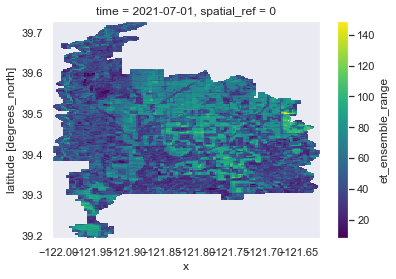

In [45]:
butte_openet['et_ensemble_range'].isel(time=-6).plot()

In [44]:
cropland_data_butte['cropland'].isel(time=-1).plot()

# Soil type / AEM data

Big questions:

- Is there any correlation with AEM data points and OpenET ensemble values


In [435]:
### let's just use Butte as an example
from shapely.geometry import Point
from scipy.spatial import cKDTree
butte_aem = pd.read_csv('../data/AEM/butte_aem.csv')
butte_aem = gpd.GeoDataFrame(
    butte_aem.drop(['UTMX', 'UTMY'], axis=1),
    crs={'init': 'epsg:3310'},
    geometry=[Point(xy) for xy in zip(butte_aem['UTMX'], butte_aem['UTMY'])])
# May 2022
butte_aem = butte_aem.to_crs('epsg:4326')
butte_aem = butte_aem.dropna()
print(butte_aem)

def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


       Unnamed: 0   rho_1   rho_2  std_1  std_2                     geometry
0               0  10.880  10.420  1.807  1.705  POINT (-121.93411 39.27880)
1               1   9.087   8.478  1.593  1.628  POINT (-121.93454 39.27932)
2               2  10.520  10.310  1.718  1.695  POINT (-121.94159 39.28763)
3               3  11.170  11.310  1.721  1.704  POINT (-121.94092 39.28690)
4               4  11.280  11.170  1.734  1.705  POINT (-121.94135 39.28738)
...           ...     ...     ...    ...    ...                          ...
14945       14945  24.120  23.460  1.530  1.745  POINT (-121.88191 39.71960)
14946       14946  24.030  23.610  1.547  1.748  POINT (-121.88154 39.71960)
14947       14947  29.390  30.460  1.696  1.798  POINT (-121.87782 39.71962)
14948       14948  30.380  31.170  1.700  1.800  POINT (-121.87669 39.71963)
14949       14949  33.780  29.480  1.675  1.810  POINT (-121.87175 39.71948)

[14950 rows x 6 columns]


In [436]:
butte_openet_aem = butte_openet.isel(time=-1).to_dataframe().reset_index().dropna()
butte_openet_aem = gpd.GeoDataFrame(
    butte_openet_aem, geometry=gpd.points_from_xy(butte_openet_aem.x,butte_openet_aem.y))

### log space and normal space

butte_openet_aem_paired = ckdnearest(butte_aem, butte_openet_aem)

In [437]:
butte_openet_aem_paired

Unnamed: 0   rho_1   rho_2  std_1  std_2                     geometry  \
0               0  10.880  10.420  1.807  1.705  POINT (-121.93411 39.27880)   
1               1   9.087   8.478  1.593  1.628  POINT (-121.93454 39.27932)   
2               2  10.520  10.310  1.718  1.695  POINT (-121.94159 39.28763)   
3               3  11.170  11.310  1.721  1.704  POINT (-121.94092 39.28690)   
4               4  11.280  11.170  1.734  1.705  POINT (-121.94135 39.28738)   
...           ...     ...     ...    ...    ...                          ...   
14945       14945  24.120  23.460  1.530  1.745  POINT (-121.88191 39.71960)   
14946       14946  24.030  23.610  1.547  1.748  POINT (-121.88154 39.71960)   
14947       14947  29.390  30.460  1.696  1.798  POINT (-121.87782 39.71962)   
14948       14948  30.380  31.170  1.700  1.800  POINT (-121.87669 39.71963)   
14949       14949  33.780  29.480  1.675  1.810  POINT (-121.87175 39.71948)   

                x          y       time  spatial_ref  DisALEXI_ET  PT-JPL_ET  \
0     -121.940160  39.277713 2021-12-01            0         26.0       25.0   
1     -121.940160  39.279959 2021-12-01            0         27.0       26.0   
2     -121.942406  39.286696 2021-12-01            0         12.0       28.0   
3     -121.940160  39.286696 2021-12-01            0         17.0       28.0   
4     -121.942406  39.286696 2021-12-01            0         12.0       28.0   
...           ...        ...        ...          ...          ...        ...   
14945 -121.881770  39.720133 2021-12-01            0         16.0       30.0   
14946 -121.881770  39.720133 2021-12-01            0         16.0       30.0   
14947 -121.877278  39.720133 2021-12-01            0         16.0       29.0   
14948 -121.877278  39.720133 2021-12-01            0         16.0       29.0   
14949 -121.872786  39.720133 2021-12-01            0         19.0       30.0   

       SIMS_ET  SSEBop_ET  eeMETRIC_ET  et_ensemble_mad  et_ensemble_mad_max  \
0         24.0       24.0         28.0             25.0                 28.0   
1         26.0       26.0         26.0             26.0                 30.0   
2         26.0       27.0         23.0             26.0                 28.0   
3         26.0       26.0         24.0             26.0                 29.0   
4         26.0       27.0         23.0             26.0                 28.0   
...        ...        ...          ...              ...                  ...   
14945     23.0       14.0          6.0             17.0                 28.0   
14946     23.0       14.0          6.0             17.0                 28.0   
14947     23.0       17.0          6.0             17.0                 27.0   
14948     23.0       17.0          6.0             17.0                 27.0   
14949     23.0       19.0          9.0             19.0                 28.0   

       et_ensemble_mad_min  geeSEBAL_ET      dist  
0                     20.0         11.0  0.006149  
1                     22.0          9.0  0.005655  
2                     21.0         10.0  0.001242  
3                     23.0         12.0  0.000786  
4                     21.0         10.0  0.001258  
...                    ...          ...       ...  
14945                  7.0         15.0  0.000554  
14946                  7.0         15.0  0.000575  
14947                  8.0         14.0  0.000746  
14948                  8.0         14.0  0.000777  
14949                  9.0         14.0  0.001231  

[14950 rows x 20 columns]

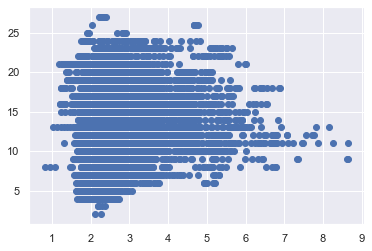

In [446]:
plt.scatter(np.log(butte_openet_aem_paired['rho_1']), 
            butte_openet_aem_paired['et_ensemble_mad_max']-butte_openet_aem_paired['et_ensemble_mad_min'])

# OLD

In [180]:
def plot_shit(dataframe):
    '''plot shit
    Plot monthly, find where maximum for rice vs. shrubland is. When is it peaking? Why is shrubland so high?
    
    Have insitu ET estimate, have 6 openET models, what is the level of agreement at pixel, pixel+neighbors, at basin
    
    Is OpenET acceptable at basin scale vs field scale?
    
    Variance of OpenET pixels within one pixel, pixel+neighbors, at basin
    
    Recalculate error with flux tower as more models are added.
    '''
    data_rice = unpack_results('rice', dataframe)
    data_shrubland = unpack_results('shrubland', dataframe)
    x_data = pd.date_range(start=pd.datetime(2017, 1, 1), periods=5, freq='AS')
    fig, axes = plt.subplots(2,1,figsize=(12,12))
    
    axes[0].plot(x_data, data_shrubland['ensemble_ET'], label='Ensemble Mean')
    axes[0].plot(x_data, data_shrubland['DisALEXI_ET'], label='DisALEXI')
    axes[0].plot(x_data, data_shrubland['PT-JPL_ET'], label='PT-JPL')
    #axes[0].plot(x_data, data_shrubland['SIMS_ET'], label='SIMS')
    next(axes[0]._get_lines.prop_cycler)
    axes[0].plot(x_data, data_shrubland['SSEBop_ET'], label='SSEBop')
    axes[0].plot(x_data, data_shrubland['eeMETRIC_ET'], label='eeMETRIC')
    axes[0].plot(x_data, data_shrubland['geeSEBAL_ET'], label='geeSEBAL')
    axes[0].tick_params(axis='both', labelsize=20)
    axes[0].set_xlabel('Water Year', fontsize=20)
    axes[0].set_ylabel('Evapotranspiration (mm)', fontsize=20)
    axes[0].set_title('Comparing OpenET: Shrubland in Butte', fontsize=24)
    
    axes[1].plot(x_data, data_rice['ensemble_ET'], label='Ensemble Mean')
    axes[1].plot(x_data, data_rice['DisALEXI_ET'], label='DisALEXI')
    axes[1].plot(x_data, data_rice['PT-JPL_ET'], label='PT-JPL')
    axes[1].plot(x_data, data_rice['SIMS_ET'], label='SIMS')
    axes[1].plot(x_data, data_rice['SSEBop_ET'], label='SSEBop')
    axes[1].plot(x_data, data_rice['eeMETRIC_ET'], label='eeMETRIC')
    axes[1].plot(x_data, data_rice['geeSEBAL_ET'], label='geeSEBAL')
    axes[1].tick_params(axis='both', labelsize=20)
    axes[1].set_xlabel('Water Year', fontsize=20)
    axes[1].set_ylabel('Evapotranspiration (mm)', fontsize=20)
    axes[1].set_title('Comparing OpenET: Rice in Butte', fontsize=24)
    axes[1].legend(fontsize=14)
    
    formatter = mdates.DateFormatter("%Y") ### formatter of the date
    locator = mdates.YearLocator() ### where to put the labels

    axes[0].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[0].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    plt.tight_layout()


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  from ipykernel import kernelapp as app


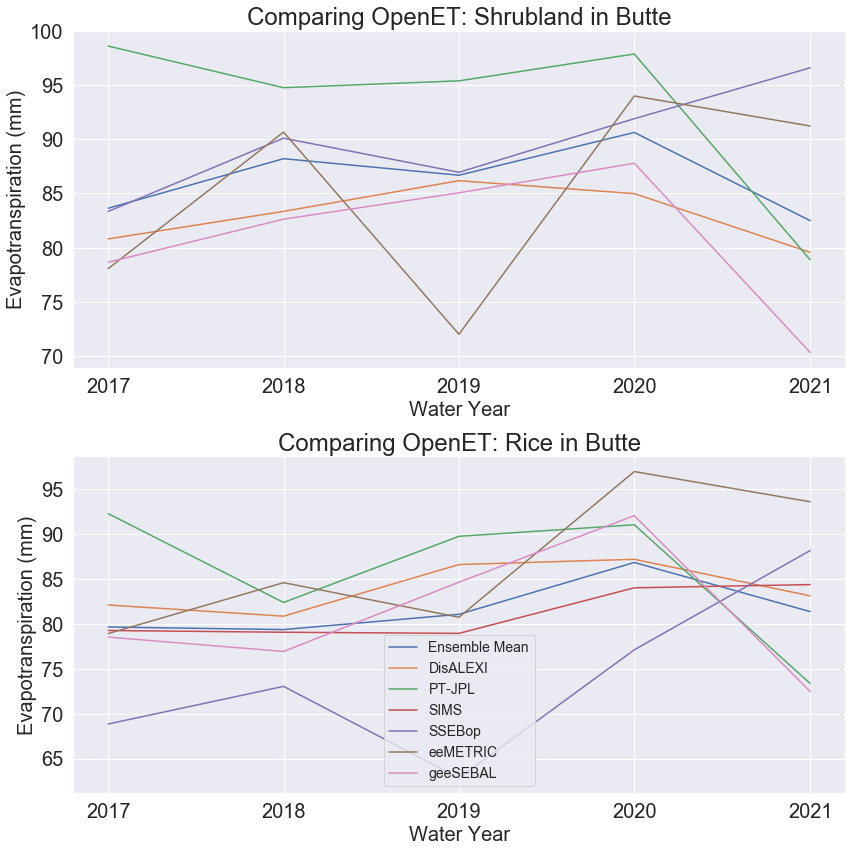

In [181]:
plot_shit(butte_results_all)

In [182]:
def plot_range_croptype(dataframe_butte, dataframe_vina, dataframe_wyandotte):
    '''plot shit
    Plot monthly, find where maximum for rice vs. shrubland is. When is it peaking? Why is shrubland so high?
    
    Have insitu ET estimate, have 6 openET models, what is the level of agreement at pixel, pixel+neighbors, at basin
    
    Is OpenET acceptable at basin scale vs field scale?
    
    Variance of OpenET pixels within one pixel, pixel+neighbors, at basin
    
    Recalculate error with flux tower as more models are added.
    '''
    data_butte_rice = unpack_results('rice', dataframe_butte)
    data_butte_shrubland = unpack_results('shrubland', dataframe_butte)
    data_butte_field = unpack_results('field', dataframe_butte)
    data_butte_fruit = unpack_results('fruit', dataframe_butte)
    data_butte_grapes = unpack_results('grapes', dataframe_butte)
    
    data_vina_rice = unpack_results('rice', dataframe_vina)
    data_vina_shrubland = unpack_results('shrubland', dataframe_vina)
    data_vina_field = unpack_results('field', dataframe_vina)
    data_vina_fruit = unpack_results('fruit', dataframe_vina)
    data_vina_grapes = unpack_results('grapes', dataframe_vina)
    
    data_wyandotte_rice = unpack_results('rice', dataframe_wyandotte)
    data_wyandotte_shrubland = unpack_results('shrubland', dataframe_wyandotte)
    data_wyandotte_field = unpack_results('field', dataframe_wyandotte)
    data_wyandotte_fruit = unpack_results('fruit', dataframe_wyandotte)
    data_wyandotte_grapes = unpack_results('grapes', dataframe_wyandotte)
    
    x_data = pd.date_range(start=pd.datetime(2017, 1, 1), periods=5, freq='AS')
    fig, axes = plt.subplots(3,1,figsize=(12,18))
    
    axes[0].plot(x_data, data_butte_shrubland['ET_range'], label='Shrubland Range Butte')
    axes[0].plot(x_data, data_butte_field['ET_range'], label='Field Range Butte')
    axes[0].plot(x_data, data_butte_fruit['ET_range'], label='Fruit Range Butte')
    axes[0].plot(x_data, data_butte_grapes['ET_range'], label='Grape Range Butte')
    axes[0].plot(x_data, data_butte_rice['ET_range'], label='Rice Range Butte')

    axes[0].tick_params(axis='both', labelsize=20)
    axes[0].set_xlabel('Water Year', fontsize=20)
    axes[0].set_ylabel('Evapotranspiration Uncertainty (mm)', fontsize=20)
    axes[0].set_title('Comparing OpenET: Land Use in Butte', fontsize=24)
    
    axes[1].plot(x_data, data_vina_shrubland['ET_range'], label='Shrubland')
    axes[1].plot(x_data, data_vina_field['ET_range'], label='Field Crops')
    axes[1].plot(x_data, data_vina_fruit['ET_range'], label='Fruit Crops')
    axes[1].plot(x_data, data_vina_grapes['ET_range'], label='Vineyards')
    axes[1].plot(x_data, data_vina_rice['ET_range'], label='Rice')
    
    axes[1].tick_params(axis='both', labelsize=20)
    axes[1].set_xlabel('Water Year', fontsize=20)
    axes[1].set_ylabel('Evapotranspiration Uncertainty (mm)', fontsize=20)
    axes[1].set_title('Comparing OpenET: Land Use in Wyandotte', fontsize=24)
    axes[1].legend(fontsize=14)
    
    axes[2].plot(x_data, data_wyandotte_shrubland['ET_range'], label='Shrubland')
    axes[2].plot(x_data, data_wyandotte_field['ET_range'], label='Field Crops')
    axes[2].plot(x_data, data_wyandotte_fruit['ET_range'], label='Fruit Crops')
    axes[2].plot(x_data, data_wyandotte_grapes['ET_range'], label='Vineyards')
    axes[2].plot(x_data, data_wyandotte_rice['ET_range'], label='Rice')
    
    axes[2].tick_params(axis='both', labelsize=20)
    axes[2].set_xlabel('Water Year', fontsize=20)
    axes[2].set_ylabel('Evapotranspiration Uncertainty (mm)', fontsize=20)
    axes[2].set_title('Comparing OpenET: Land Use in Vina', fontsize=24)

    
    formatter = mdates.DateFormatter("%Y") ### formatter of the date
    locator = mdates.YearLocator() ### where to put the labels

    axes[0].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[0].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axes[2].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axes[2].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    plt.tight_layout()

In [183]:
plot_range_croptype(butte_results_all, vina_results_all, wyandotte_results_all)

/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


In [146]:
butte_rice = unpack_results('rice', butte_results_all)
butte_shrubland = unpack_results('shrubland', butte_results_all)

In [147]:
butte_rice['ensemble_ET']

[79.6435888504854,
 79.35447550793968,
 81.05581031379607,
 86.82731655900807,
 81.35894948892039]

In [86]:
plt.figure()
plt.plot(butte_rice['ensemble_ET'], label='Ensemble Mean')
plt.plot(butte_rice['DisALEXI_ET'], label='DisALEXI')
plt.plot(butte_rice['PT-JPL_ET'], label='PT-JPL')
plt.plot(butte_rice['SIMS_ET'], label='SIMS')
plt.plot(butte_rice['SSEBop_ET'], label='SSEBop')
plt.plot(butte_rice['eeMETRIC_ET'], label='eeMETRIC')
plt.plot(butte_rice['geeSEBAL_ET'], label='geeSEBAL')
plt.legend()

In [88]:
plt.figure()
plt.plot(butte_shrubland['ensemble_ET'], label='Ensemble Mean')
plt.plot(butte_shrubland['DisALEXI_ET'], label='DisALEXI')
plt.plot(butte_shrubland['PT-JPL_ET'], label='PT-JPL')
#plt.plot(butte_shrubland['SIMS_ET'], label='SIMS')
plt.plot(butte_shrubland['SSEBop_ET'], label='SSEBop')
plt.plot(butte_shrubland['eeMETRIC_ET'], label='eeMETRIC')
plt.plot(butte_shrubland['geeSEBAL_ET'], label='geeSEBAL')
plt.legend()

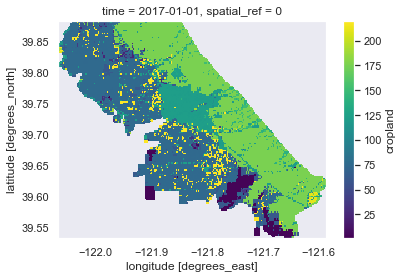

In [12]:
vina_cropland_2017.plot()

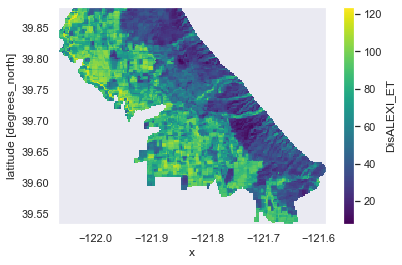

In [13]:
vina_openet_2017['DisALEXI_ET'].plot()

In [14]:
vina_cropland_2017

<xarray.DataArray 'cropland' (y: 156, x: 214)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 -122.1 -122.1 -122.1 ... -121.6 -121.6 -121.6
  * y            (y) float64 39.88 39.88 39.88 39.88 ... 39.54 39.54 39.54 39.53
    time         datetime64[ns] 2017-01-01
    spatial_ref  int64 0
Attributes:
    scales:                  1.0
    offsets:                 0.0
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    grid_mapping:            spatial_ref

In [15]:
butte_2017_openet_crop_types = compute_crop_type_et(butte_cropland_2017, butte_openet_2017)
vina_2017_openet_crop_types = compute_crop_type_et(vina_cropland_2017, vina_openet_2017)
wyandotte_2017_openet_crop_types = compute_crop_type_et(wyandotte_cropland_2017, wyandotte_openet_2017)

In [16]:
for i in range(len(butte_2017_openet_crop_types)):
    print(butte_2017_openet_crop_types[i])

{'DisALEXI_ET': 81.70798863525472, 'PT-JPL_ET': 94.98762932973459, 'SIMS_ET': 75.58461538461539, 'SSEBop_ET': 83.2314439946019, 'eeMETRIC_ET': 78.62175738491528, 'geeSEBAL_ET': 78.48455540560802}
{'DisALEXI_ET': 79.18703598550297, 'PT-JPL_ET': 88.67894291243347, 'SIMS_ET': 79.48858201911871, 'SSEBop_ET': 70.82712868892114, 'eeMETRIC_ET': 73.96929124334785, 'geeSEBAL_ET': 72.00534591194969}
{'DisALEXI_ET': 81.3205052707077, 'PT-JPL_ET': 92.32477940413163, 'SIMS_ET': 86.16856182622513, 'SSEBop_ET': 75.38793729886847, 'eeMETRIC_ET': 66.13983182809095, 'geeSEBAL_ET': 73.99445655559015}
{'DisALEXI_ET': nan, 'PT-JPL_ET': nan, 'SIMS_ET': nan, 'SSEBop_ET': nan, 'eeMETRIC_ET': nan, 'geeSEBAL_ET': nan}
{'DisALEXI_ET': 72.27760952957804, 'PT-JPL_ET': 85.62406622249142, 'SIMS_ET': 83.12690250925546, 'SSEBop_ET': 62.719362002826564, 'eeMETRIC_ET': 53.18413082980012, 'geeSEBAL_ET': 63.75005047445993}
{'DisALEXI_ET': 82.46712730552856, 'PT-JPL_ET': 87.72522751833098, 'SIMS_ET': 79.14382191095548, 'SS

In [18]:
#unique_crops, unique_counts = np.unique(np.array(cropland_2017), return_counts=True)
#sorted_indices = np.argsort(unique_counts)
#sorted_counts = unique_counts[sorted_indices][::-1]
#sorted_crops = unique_crops[sorted_indices][::-1]

In [19]:
np.set_printoptions(threshold=np.inf)

In [20]:
#print(sorted_crops[:40])

In [ ]:
def transform_irrigated(cropland):
    ''' Transform a new formatted cropland into irrigated/nonirrigated/other
    '''
    
    # irrigated - 5,8,9
    # nonirrigated - 4
    # other - 2,3
    # none - 0,1

In [ ]:
cropland_2017_array = transform_cropland(np.array(cropland_2017))

In [ ]:
butte_openet_2017_shrubland_mean = butte_openet_2017_shrubland.mean(['x','y'])
butte_openet_2017_fallowed_mean = butte_openet_2017_fallowed.mean(['x','y'])
butte_openet_2017_tree_mean = butte_openet_2017_tree.mean(['x','y'])
butte_openet_2017_grapes_mean = butte_openet_2017_grapes.mean(['x','y'])
butte_openet_2017_fruit_mean = butte_openet_2017_fruit.mean(['x','y'])
butte_openet_2017_rice_mean = butte_openet_2017_rice.mean(['x','y'])

In [ ]:
butte_openet_2017_rice_pd = convert_xarray_openet_to_pandas(butte_openet_2017_rice_mean)
butte_openet_2017_shrubland_pd = convert_xarray_openet_to_pandas(butte_openet_2017_shrubland_mean)

In [312]:
butte_openet_2017_rice_pd = convert_xarray_openet_to_pandas(butte_openet_2017_rice_mean)
butte_openet_2017_shrubland_pd = convert_xarray_openet_to_pandas(butte_openet_2017_shrubland_mean)

## new cropland

In [343]:
#new_cropland_2016 = gpd.read_file('../data/cropland/i15_Crop_Mapping_2016_SHP/i15_Crop_Mapping_2016.shp')